In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join
import pickle
import pandas as pd
from copy import deepcopy
from scipy import ndimage

In [32]:
def calc_fr_map(st, position, border, bin_cm=2, smooth=False):
    '''Firing rate at each xy position for 1 cell'''
    times = position['Timestamp']
    x = position['X']
    y = position['Y']
    occupancy, xbins, ybins, _ = calc_occupancy(position, border, bin_cm)
    binned_spikes = bin_spikes(st, times)
    spike_map = get_spike_map(binned_spikes, x, y, xbins, ybins)
    fr_map = get_fr_map(spike_map, occupancy)
    if smooth:
        fr_map = smooth_2d_map(fr_map)
        
    max_bin = np.where(spike_map==np.max(spike_map))
    x = max_bin[0][0]
    y = max_bin[1][0]
    max_fr = spike_map[x,y]/occupancy[x,y]
    return fr_map, xbins, ybins, max_fr

def bin_spikes(st, times):
    '''Converts spiketimes to spikecounts binned by times (e.g. camera frames) for 1 cell'''
    # add a bin to the end so # bins matches # position datapoints
    times = np.asarray(times)
    timestep = times[-1]/len(times)
    bins = np.append(times, times[-1]+timestep)
    binned_spikes = np.histogram(st, bins)
    return binned_spikes[0]

def get_spike_map(bin_spikes, x, y, x_bin_edges, y_bin_edges):
    """
    :param np.array bin_spikes: spike counts by time bin
    :param np.array x: x bin position of animal
    :param np.array y: y bin position of animal
    :param x_bin_edges: np.array of edges
    :param y_bin_edges: np.array of edges
    :return: np.ndarray spike_map: number of spikes at each xy position
    """
    x_spk, y_spk = get_bin_spikes_xy(bin_spikes, x, y)
    spike_map, _, _ = np.histogram2d(y_spk, x_spk, bins=[y_bin_edges, x_bin_edges])
    return spike_map

def get_bin_spikes_xy(bin_spikes, x, y):
    """
    :param np.array bin_spikes: spike counts by time bin
    :param np.array x: x bin position of animal
    :param np.array y: y bin position of animal
    :return: np.arrays x_spikes, y_spikes: positions for each spike (length=n_spikes)
    """
    max_n_spikes = np.max(bin_spikes)
    x_spikes = []
    y_spikes = []
    for n_spk in np.arange(1, max_n_spikes + 1):
        x_spikes += x[bin_spikes == n_spk].tolist() * int(n_spk)
        y_spikes += y[bin_spikes == n_spk].tolist() * int(n_spk)
    assert len(x_spikes) == np.sum(bin_spikes), 'Spikes To Position Mismatch'
    return x_spikes, y_spikes

def get_fr_map(spike_map, pos_map_secs):
    """
    :param np.ndarray spike_map: number of spikes at each xy position
            -> as returned by get_spike_map()
    :param np.ndarray pos_map_secs: occupation map in seconds
            -> obtained from get_position_map() and normalized by the time_step
    :return: np.ndarray fr_map: same shape as the inputs. firing rate at each xy position
            -> will probably need smoothing after
    """
    pos_map_secs2 = np.array(pos_map_secs, dtype=np.float32)
    pos_map_secs2[pos_map_secs == 0] = np.nan  # convert zero occupation bins to nan
    fr_map = spike_map / pos_map_secs2
    fr_map[np.isnan(fr_map)] = 0  # convert zero occupation bins to 0
    return fr_map

def smooth_2d_map(bin_map, n_bins=2, sigma=1.5, apply_median_filt=True, **kwargs):
    """
    :param bin_map: map to be smooth.
        array in which each cell corresponds to the value at that xy position
    :param n_bins: number of smoothing bins
    :param sigma: std for the gaussian smoothing
    :return: sm_map: smoothed map. note that this is a truncated sigma map, meaning that high or
            low values wont affect far away bins
    """
    if apply_median_filt:
        sm_map = ndimage.median_filter(bin_map, n_bins, mode='constant')
    else:
        sm_map = bin_map

    return ndimage.gaussian_filter(sm_map, sigma, mode='constant')

def plot_position(position, border, spikes=None, by_segment=False):
    '''Plot position trace over entire session within borders
    Optionally overlay spikes from a single cell'''

    fig, ax = plt.subplots()
    us_per_frame = 51
    
    # plot borders
    points = deepcopy(border)
    points.append(points[0])
    x, y = zip(*points)
    ax.plot(x, y)

    # plot trajectory
    if by_segment:
        ax.scatter(position['X'], position['Y'], s=10,
            c=position['Segment'], cmap=plt.cm.RdYlBu,
            rasterized=True)
    else:
        ax.plot(position['X'], position['Y'], color='k',
            rasterized=True, zorder=1)

    if spikes is not None:
        hist_bins = np.asarray(position['Timestamp'])
        hist_bins = np.append(hist_bins, hist_bins[-1]+us_per_frame)
        spike_hist, _ = np.histogram(spikes, bins=hist_bins)
        x = position['X'][spike_hist > 0]
        y = position['Y'][spike_hist > 0]
        ax.scatter(x, y, color='r', rasterized=True, zorder=2)

    plt.show()
    return fig

def calc_occupancy(position, border, bin_cm=2, weights=None):
    '''Calculate occupancy matrix of bins of size bin_cm visited by mouse'''
    x = position['X']
    y = position['Y']
    wall_max = np.max(border, axis=0)
    xbins = np.linspace(bin_cm, wall_max[0], int(wall_max[0]/bin_cm)+1)
    ybins = np.linspace(bin_cm, wall_max[1], int(wall_max[1]/bin_cm)+1)
    # invert x & y so it plots corectly
    occupancy, _, _ = np.histogram2d(y, x, [ybins, xbins], weights=weights)
    # convert to seconds
    us_per_frame = 51
    occupancy *= us_per_frame/10**3
    # note that coverage is only meaningful for open field (box)
    coverage = np.sum(occupancy > 0)/(len(xbins)*len(ybins))
    return occupancy, xbins, ybins, coverage

def plot_heatmap(occupancy, xbins, ybins):
    '''Plot heatmap, eg occupancy'''
    fig, ax = plt.subplots()
    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
    cmap = mpl.cm.get_cmap("afmhot").copy()
    cmap.set_bad(color='grey')
    ax.imshow(occupancy, extent=extent, origin='lower', cmap=cmap)
    ax.set(xticks=[], yticks=[])
    plt.show()
    return fig

0


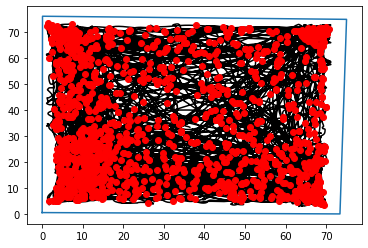

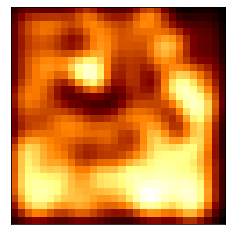

1


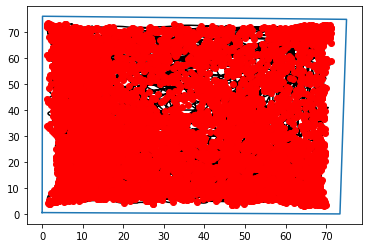

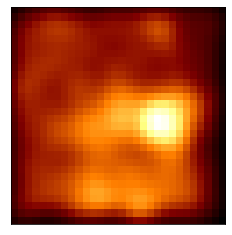

2


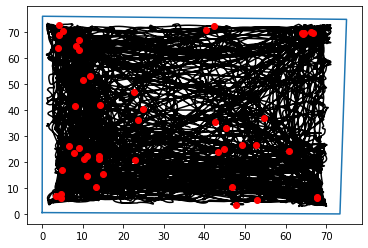

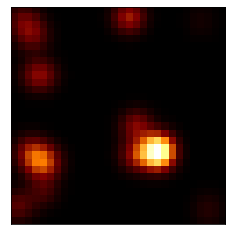

3


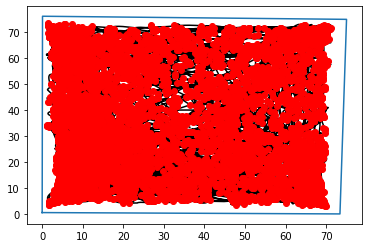

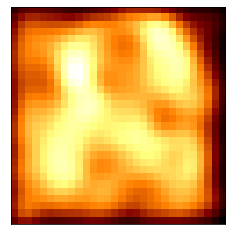

4


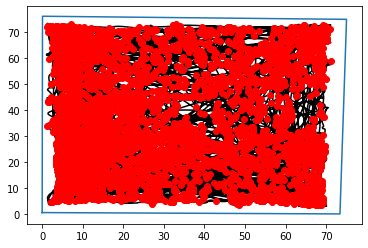

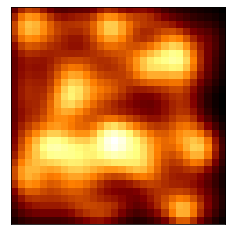

5


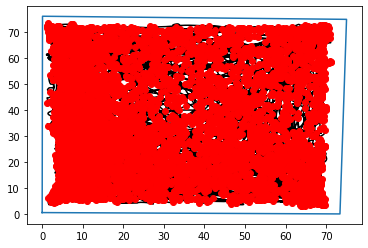

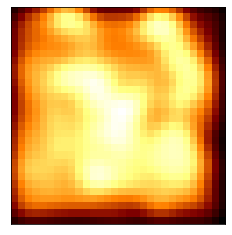

6


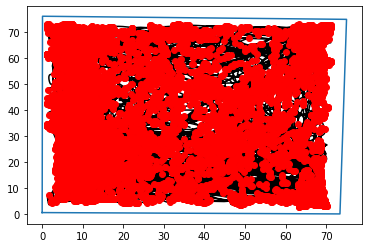

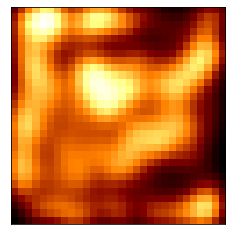

7


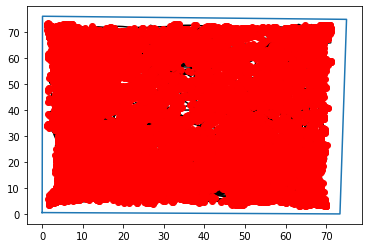

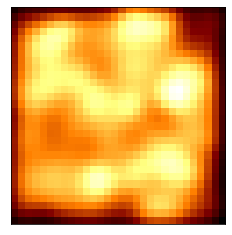

8


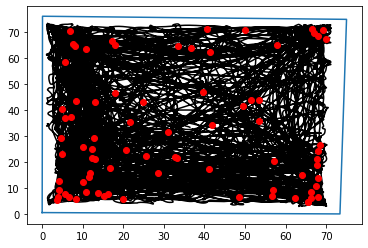

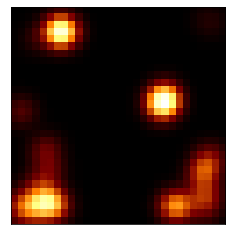

9


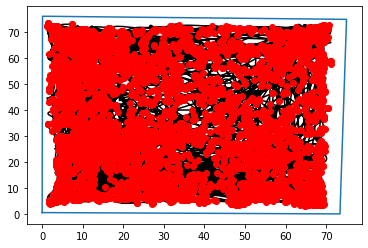

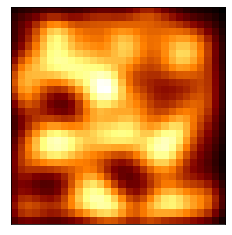

10


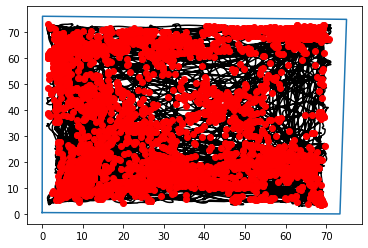

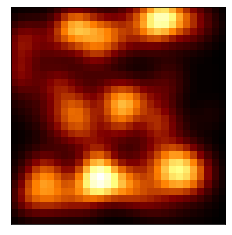

11


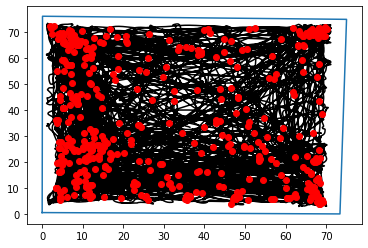

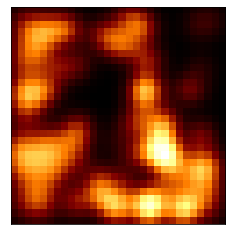

12


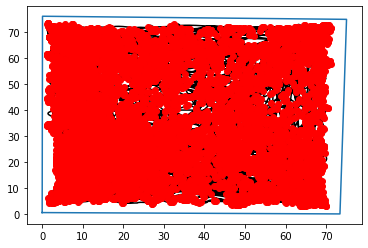

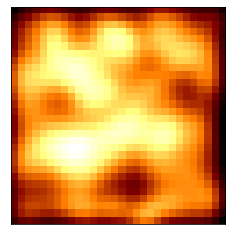

13


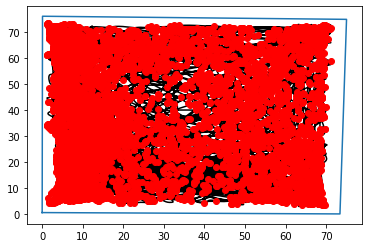

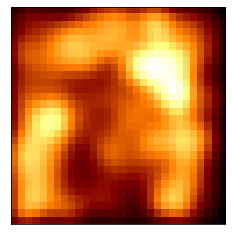

14


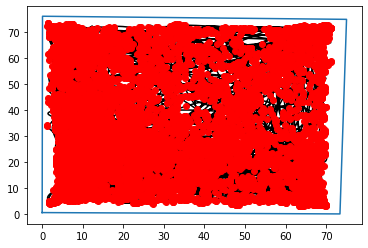

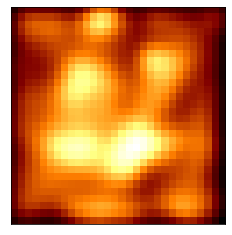

15


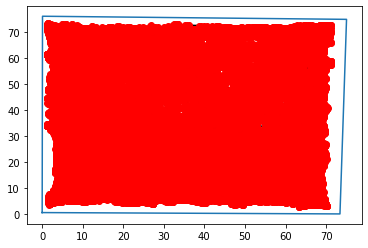

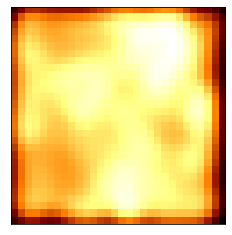

16


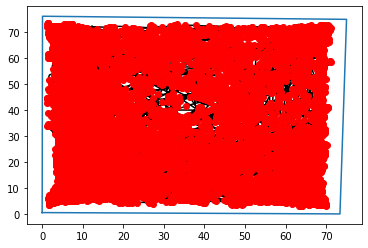

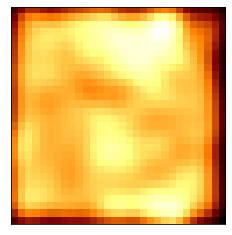

17


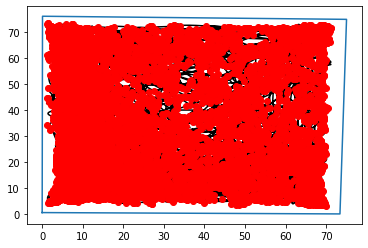

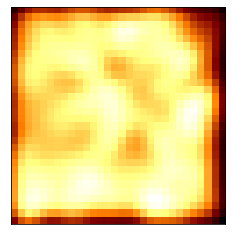

18


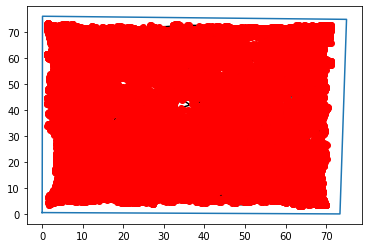

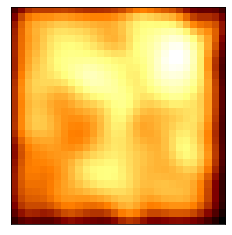

19


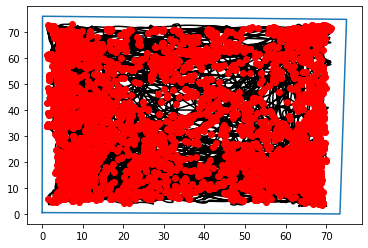

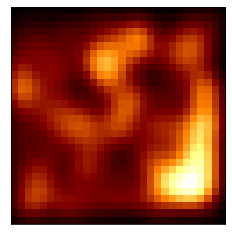

20


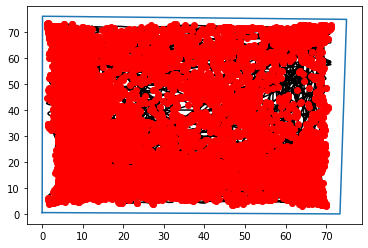

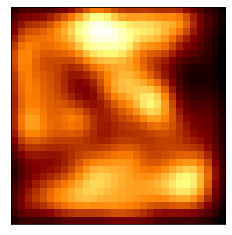

21


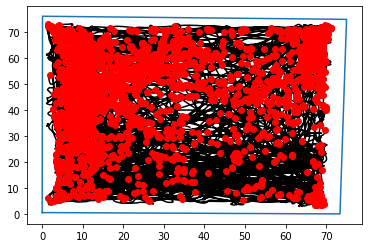

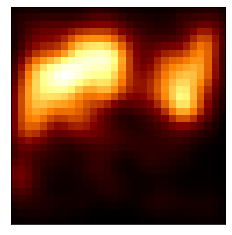

22


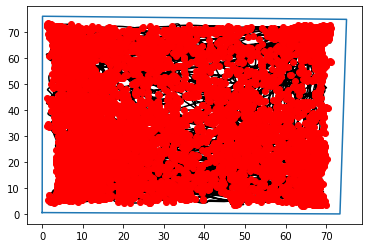

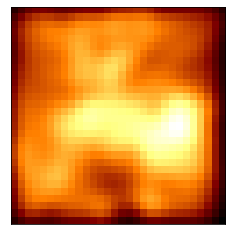

23


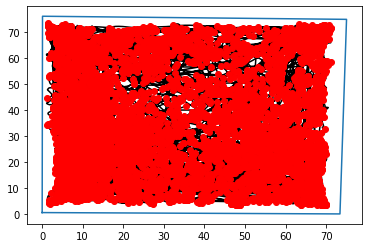

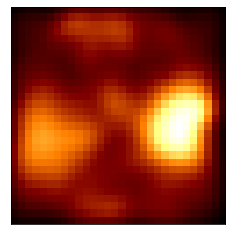

24


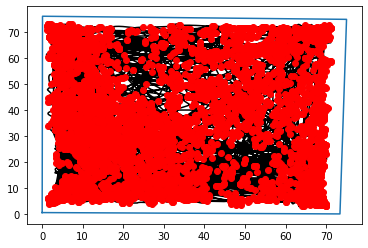

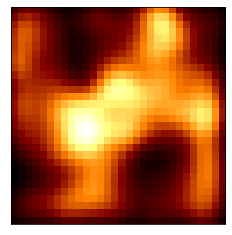

25


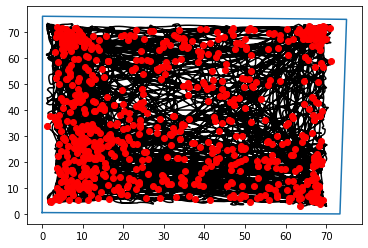

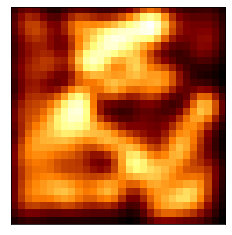

26


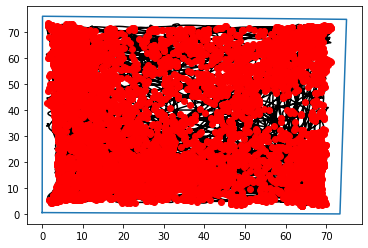

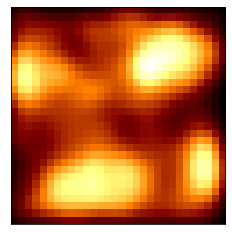

27


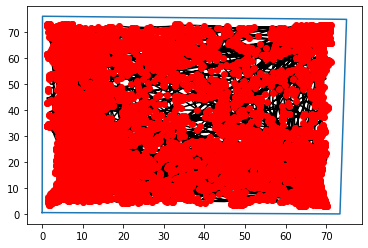

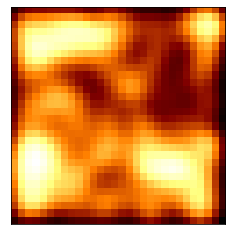

28


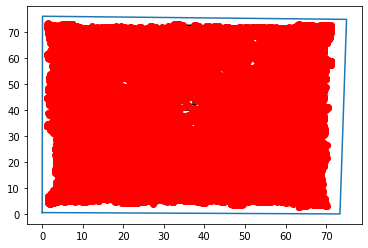

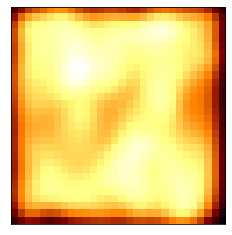

29


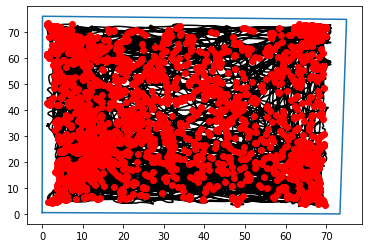

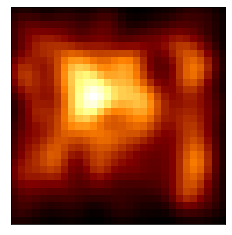

30


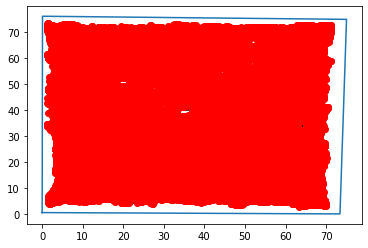

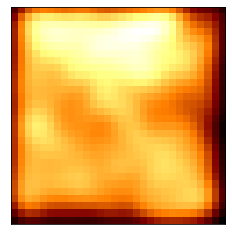

31


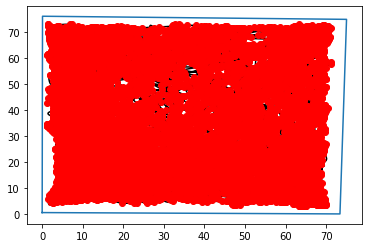

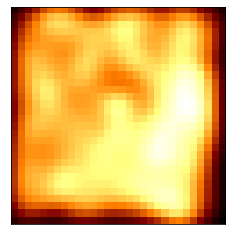

32


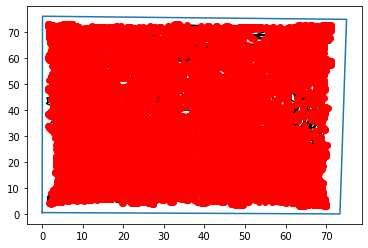

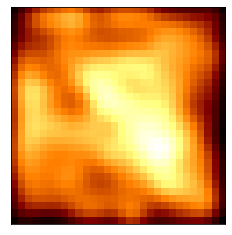

33


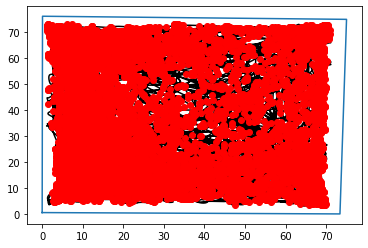

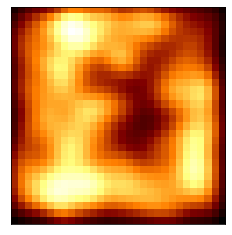

34


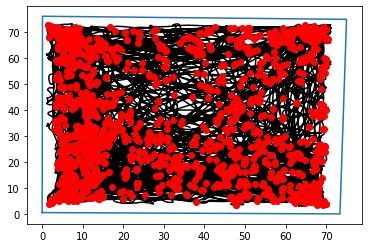

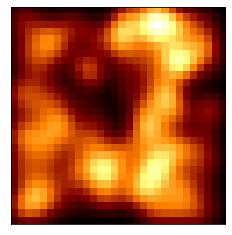

35


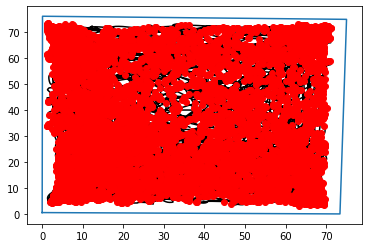

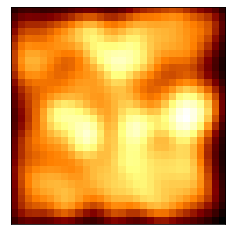

36


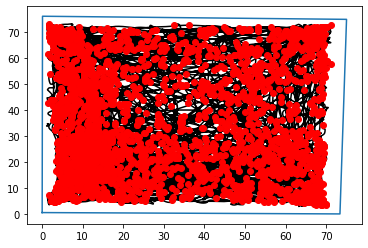

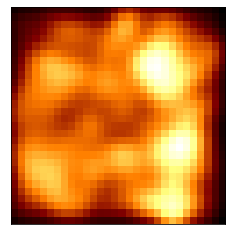

37


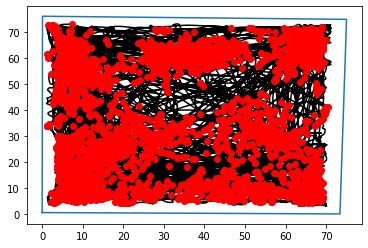

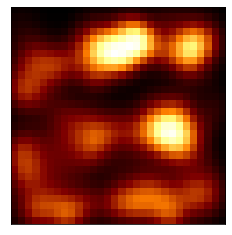

38


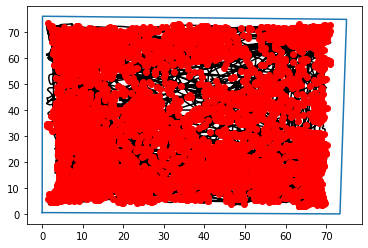

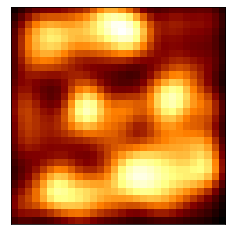

39


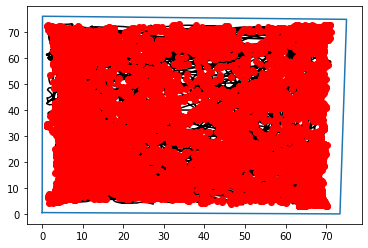

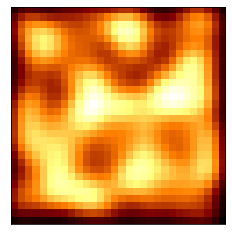

40


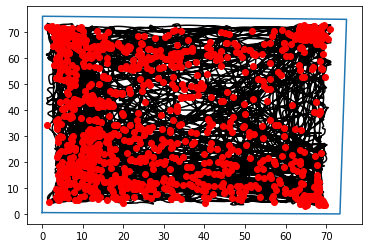

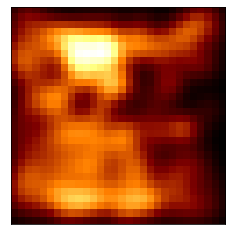

41


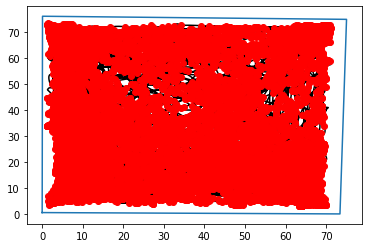

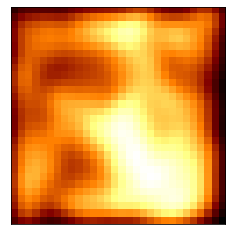

42


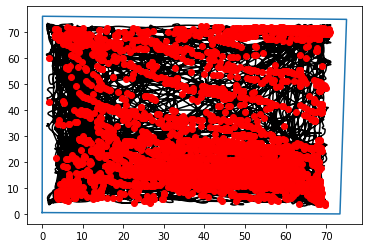

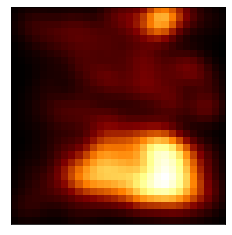

43


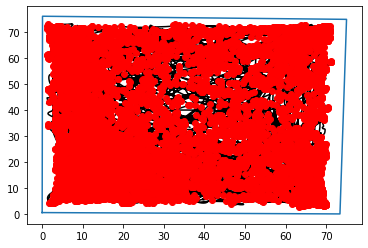

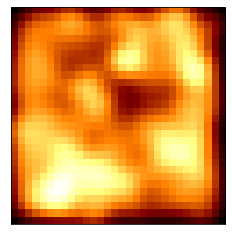

44


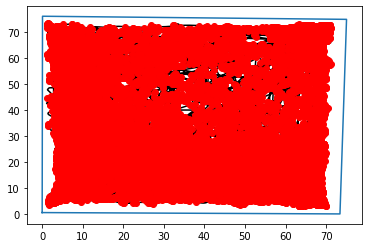

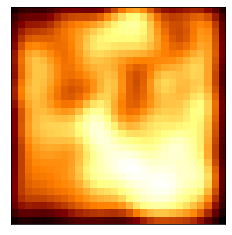

45


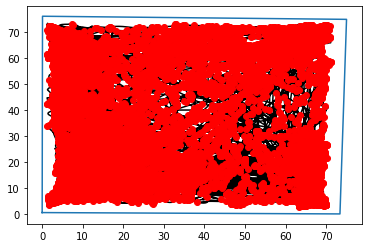

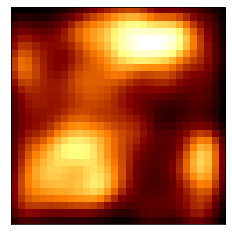

46


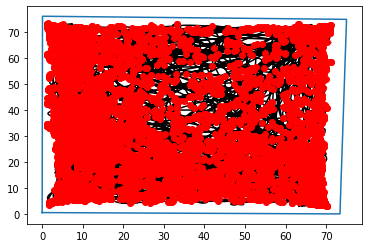

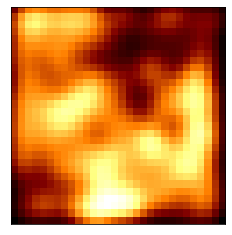

47


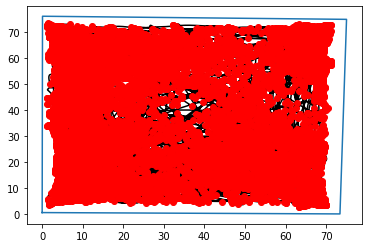

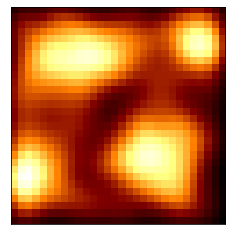

48


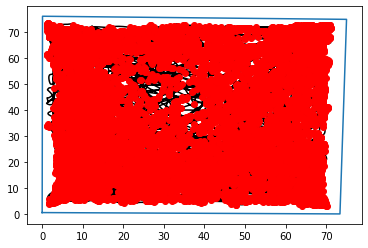

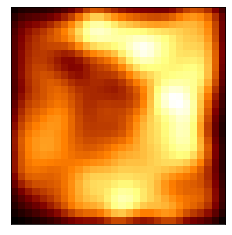

49


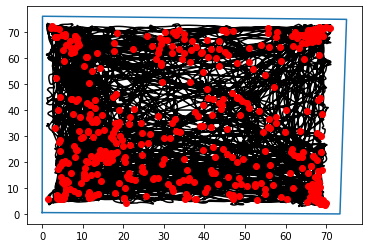

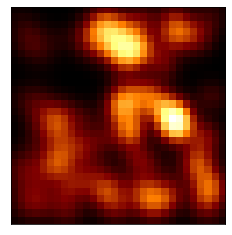

50


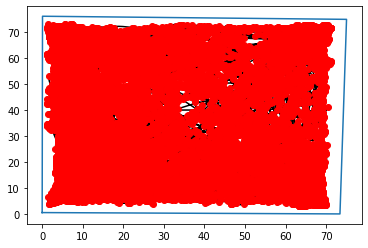

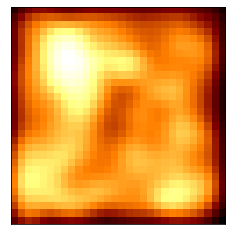

51


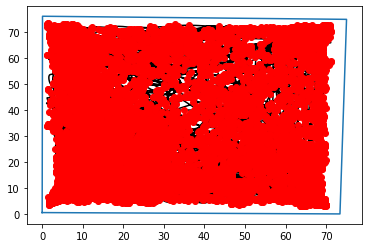

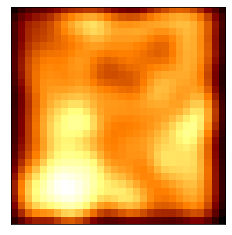

52


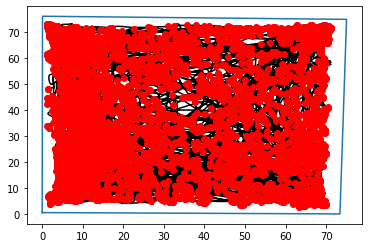

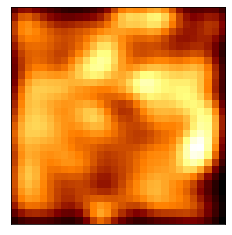

53


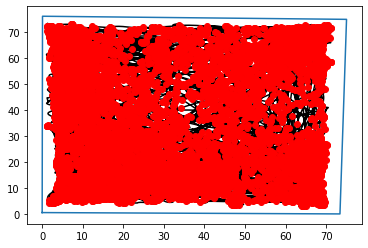

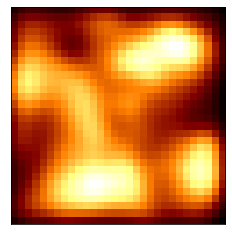

54


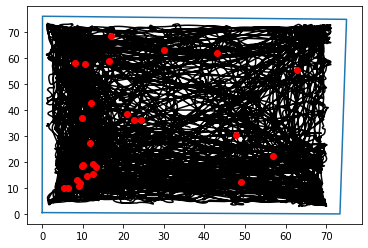

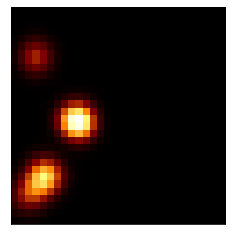

55


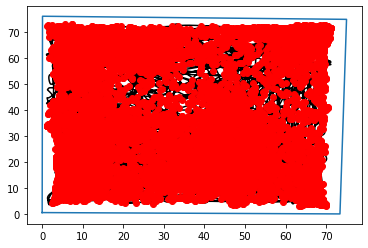

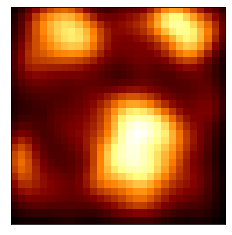

56


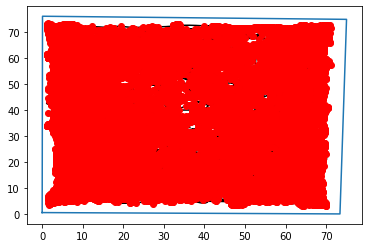

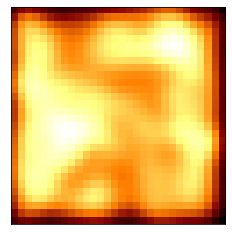

57


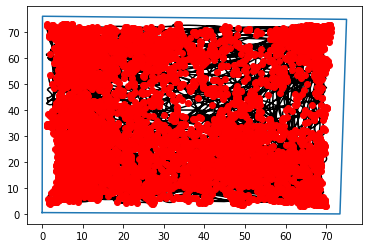

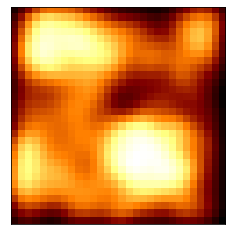

58


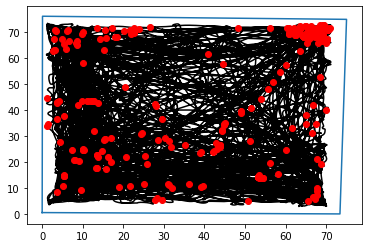

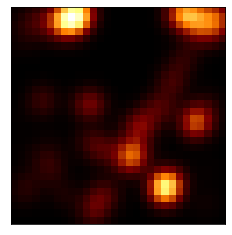

59


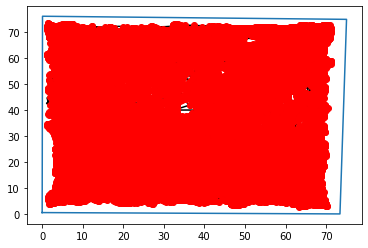

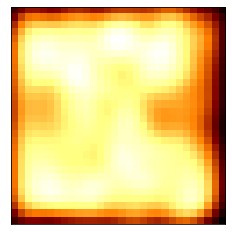

60


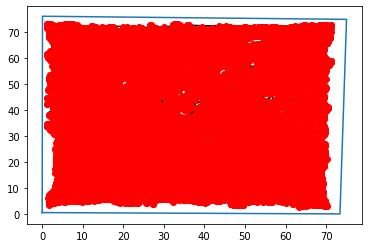

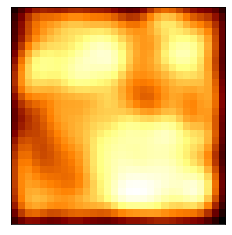

61


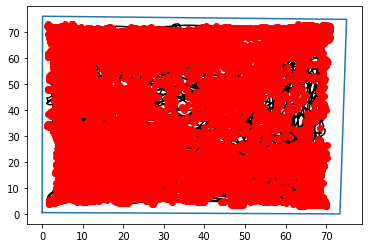

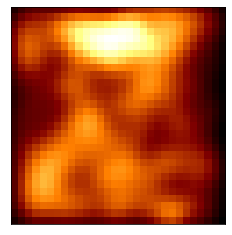

62


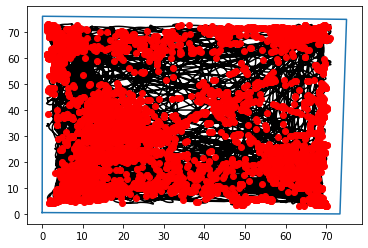

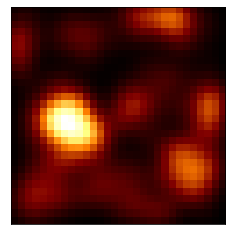

63


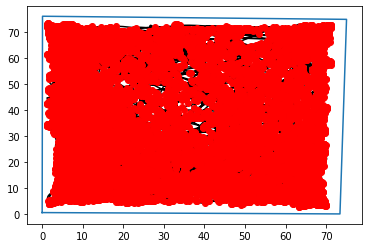

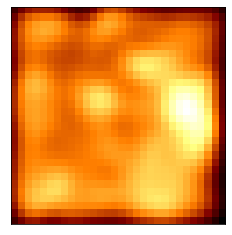

64


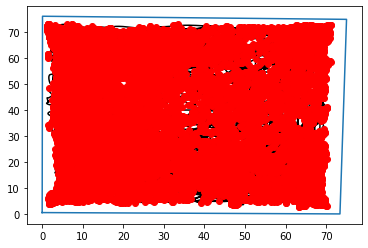

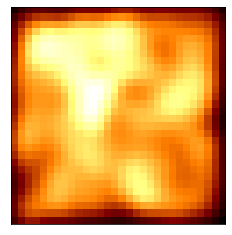

65


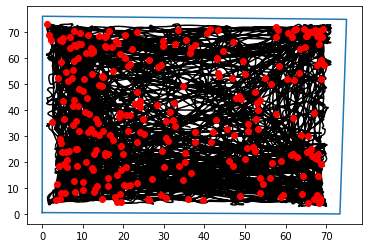

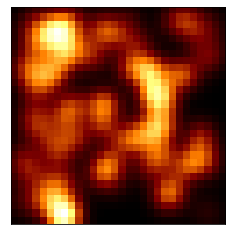

66


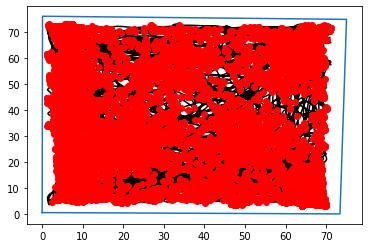

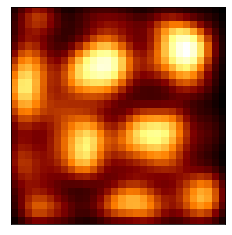

67


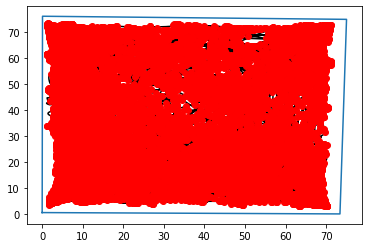

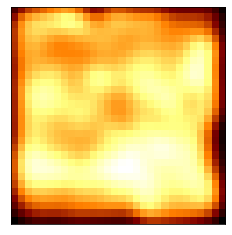

68


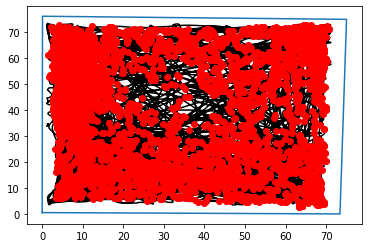

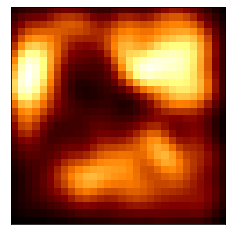

69


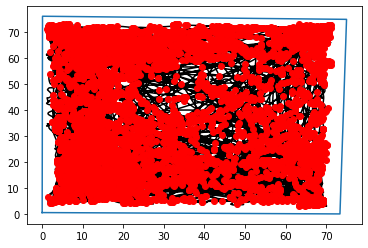

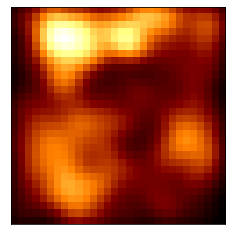

70


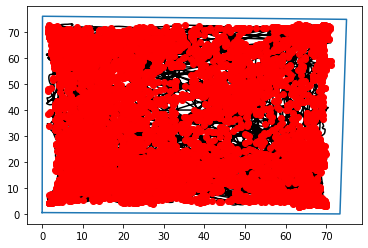

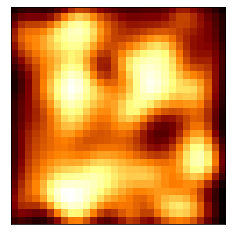

71


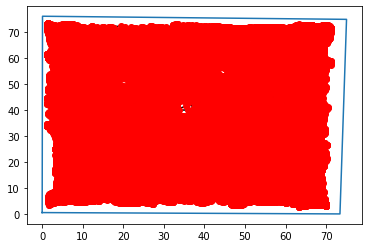

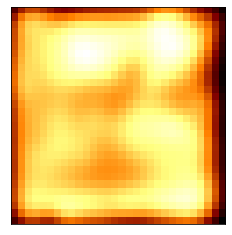

72


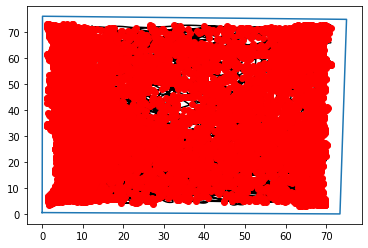

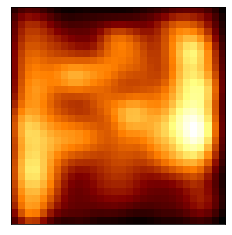

73


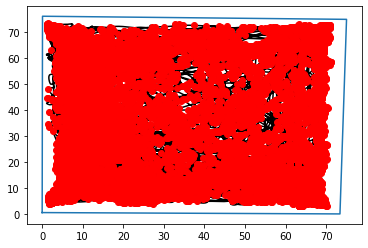

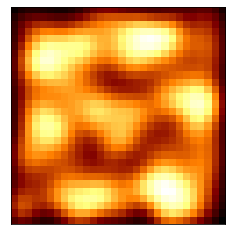

74


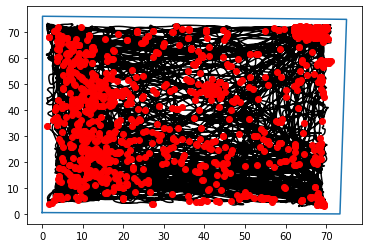

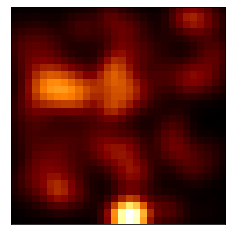

75


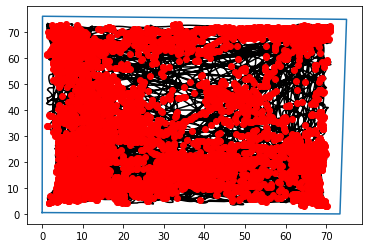

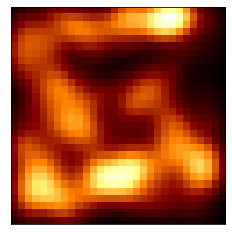

76


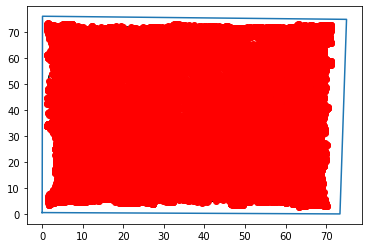

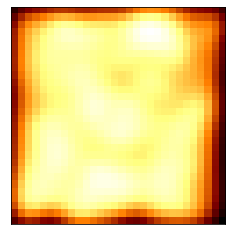

77


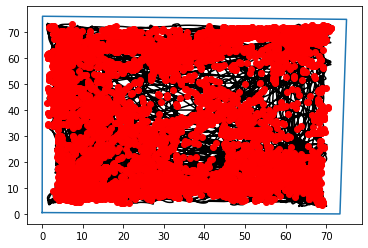

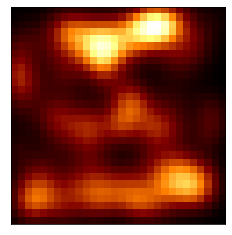

78


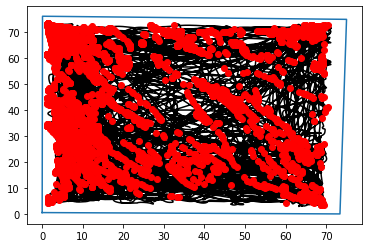

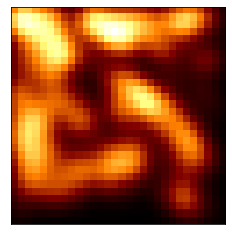

79


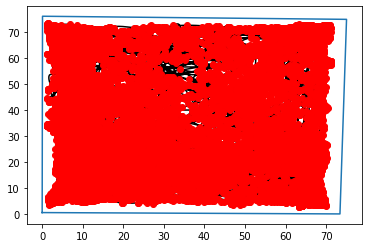

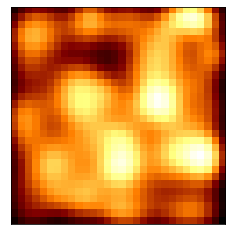

80


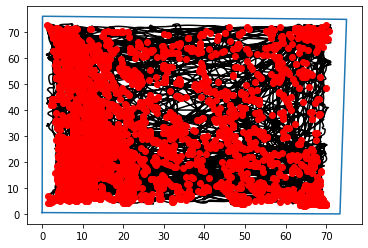

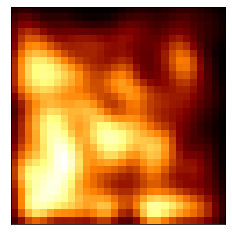

81


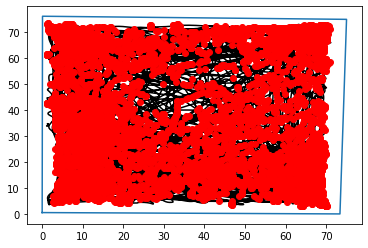

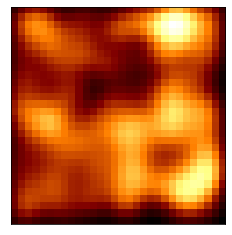

82


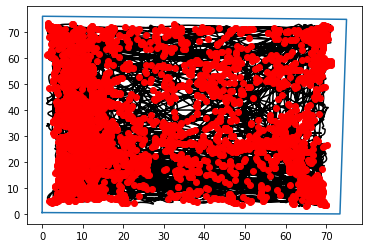

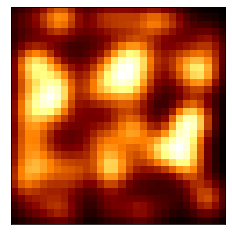

83


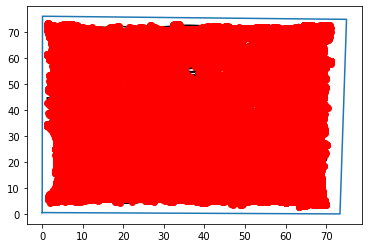

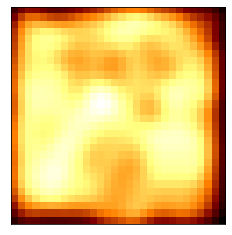

84


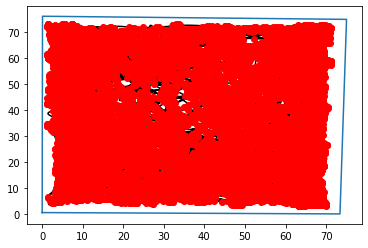

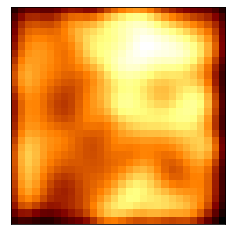

85


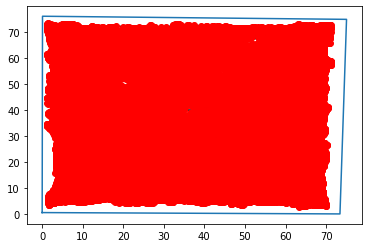

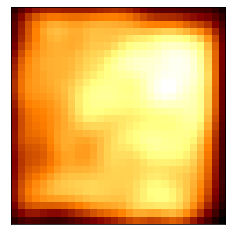

86


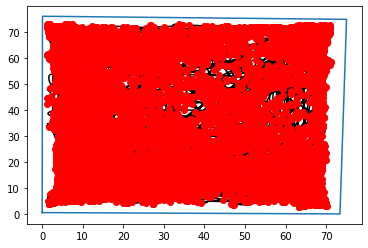

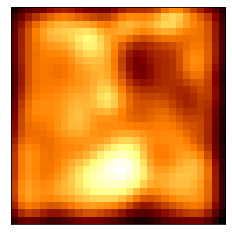

87


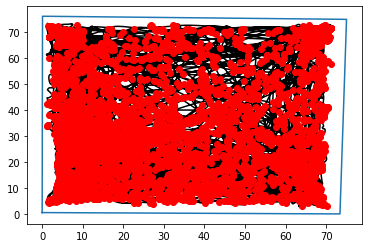

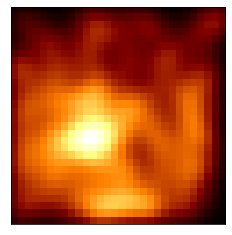

88


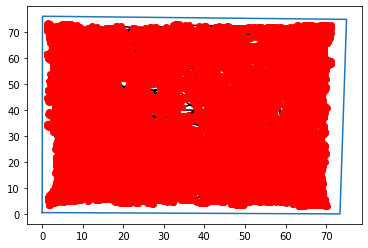

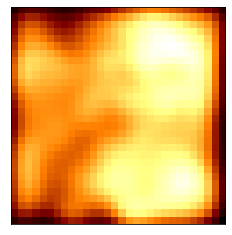

89


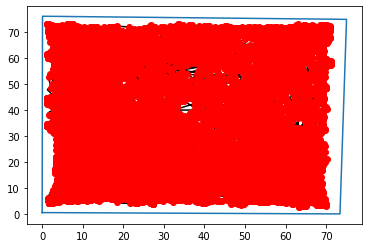

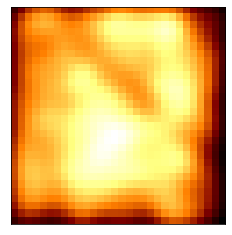

90


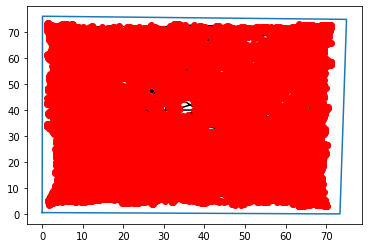

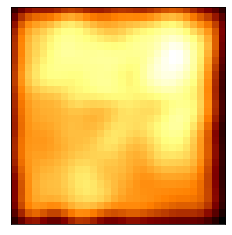

91


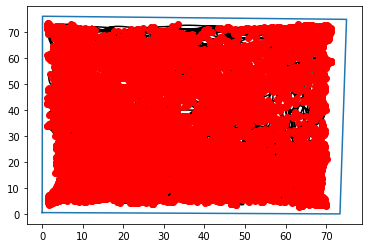

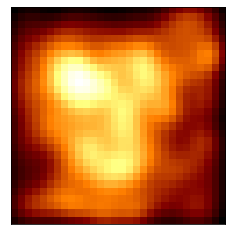

92


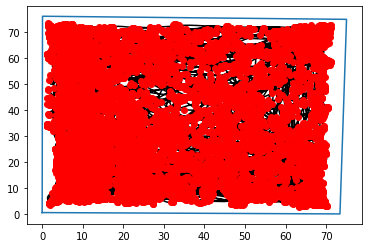

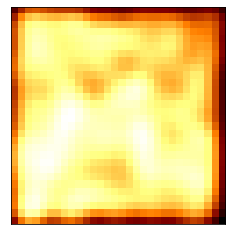

93


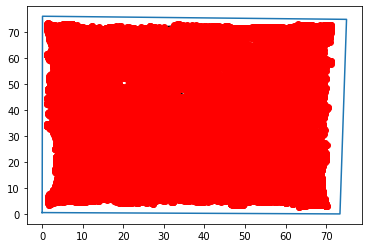

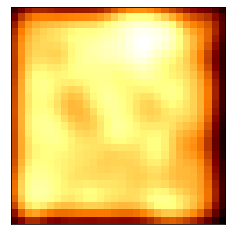

94


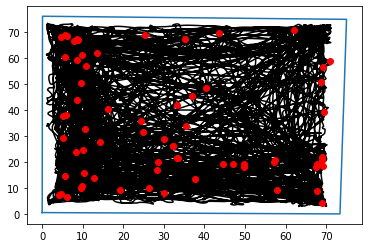

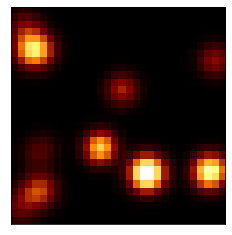

95


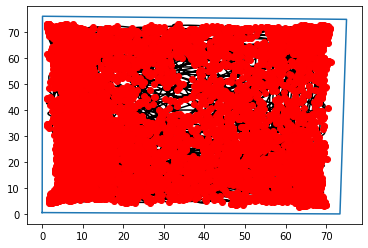

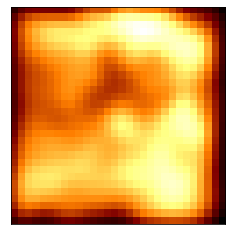

96


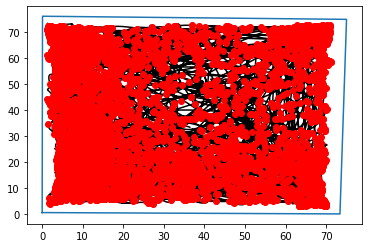

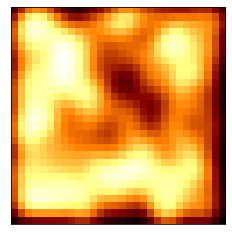

97


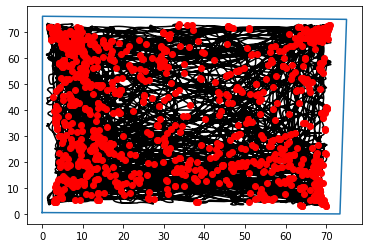

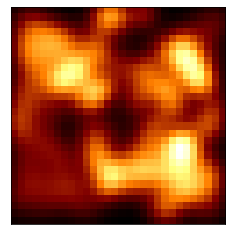

98


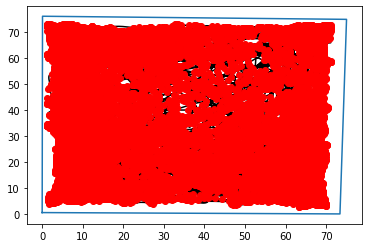

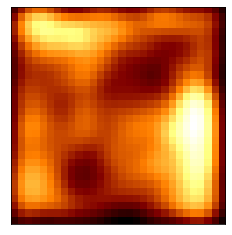

99


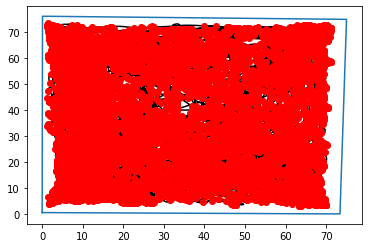

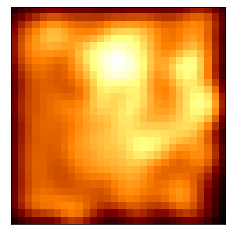

100


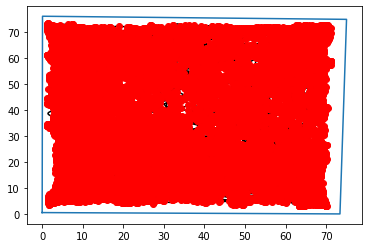

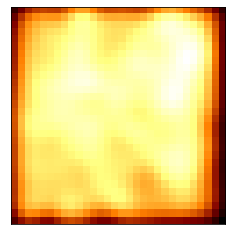

101


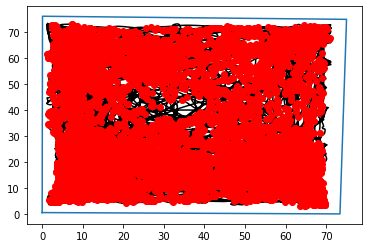

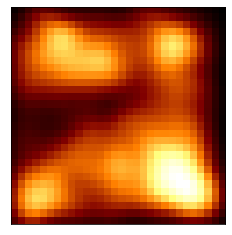

102


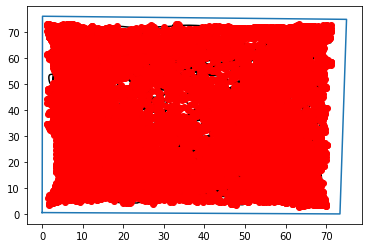

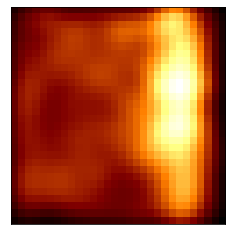

103


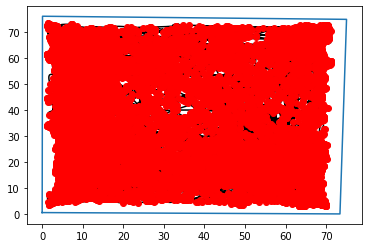

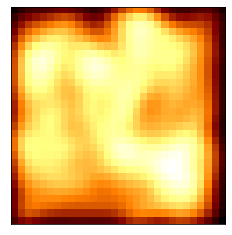

104


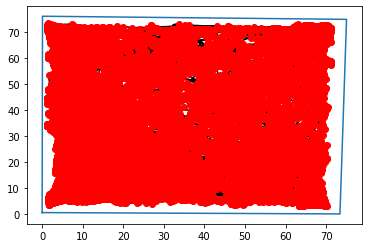

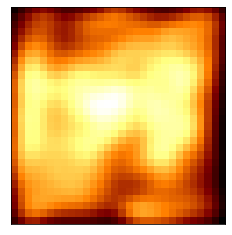

105


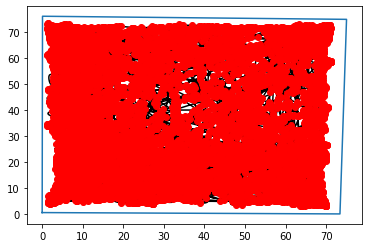

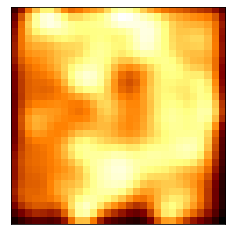

106


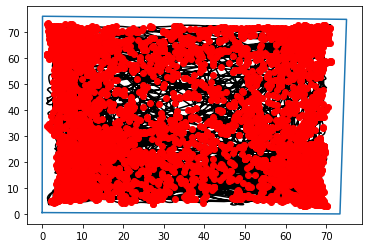

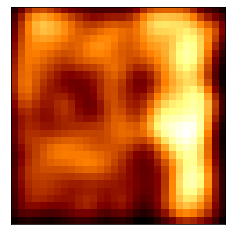

107


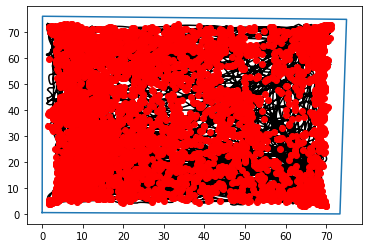

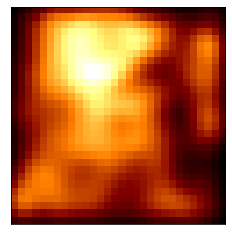

108


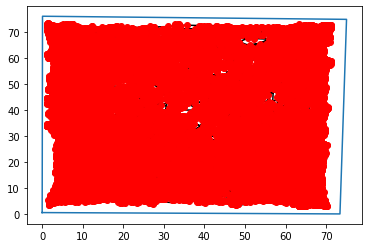

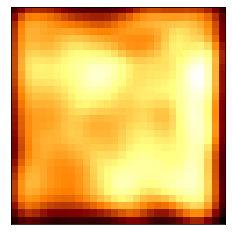

109


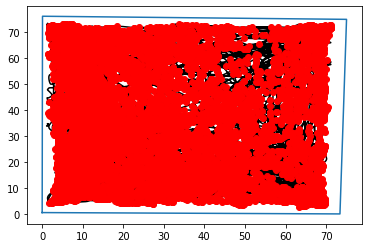

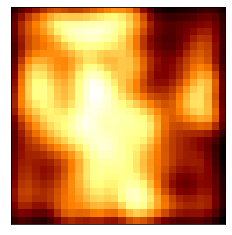

110


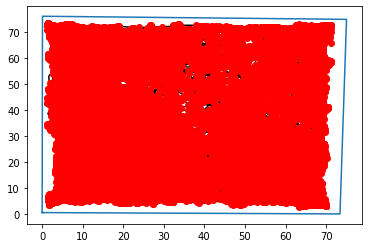

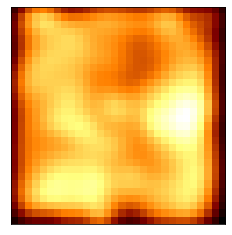

111


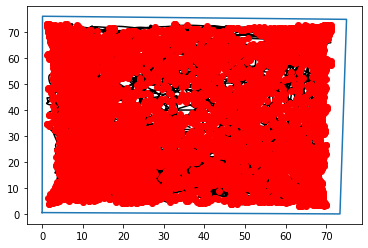

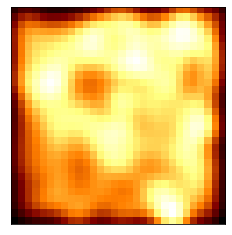

112


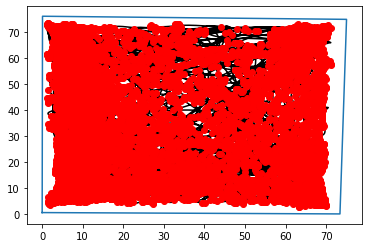

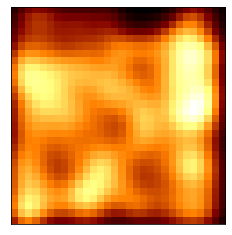

113


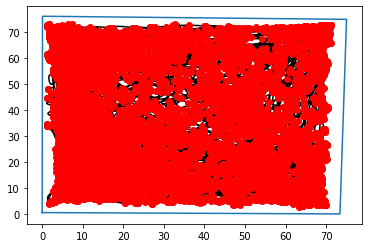

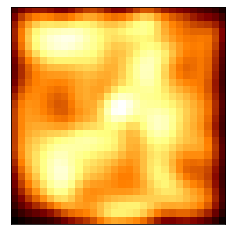

114


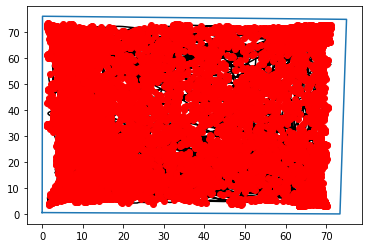

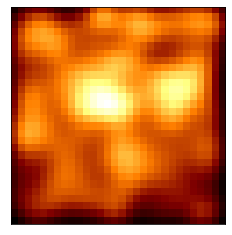

115


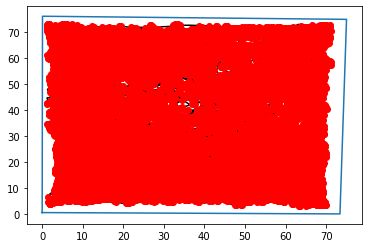

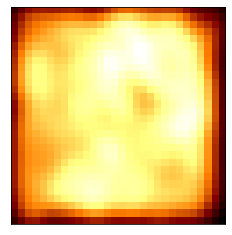

116


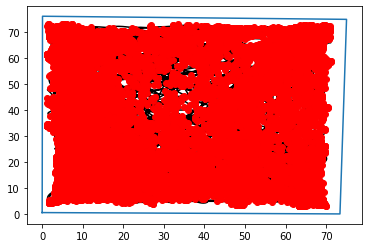

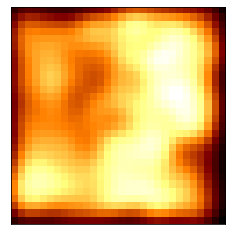

117


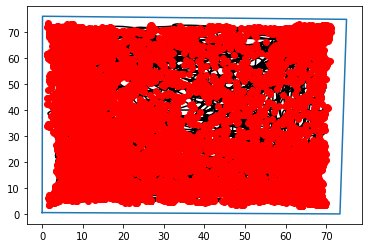

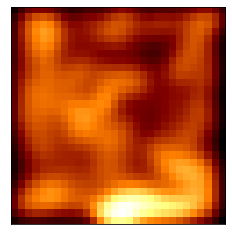

118


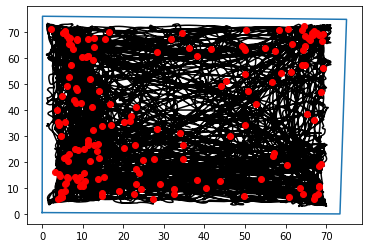

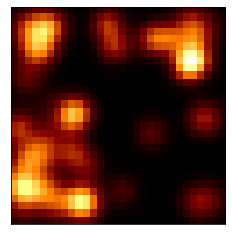

119


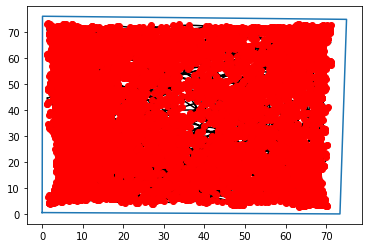

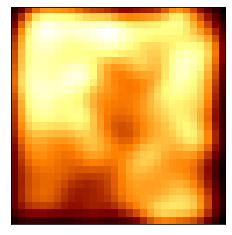

120


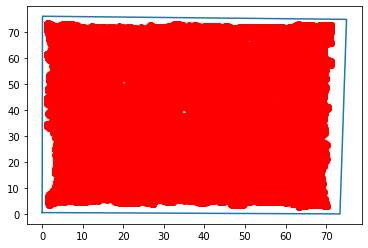

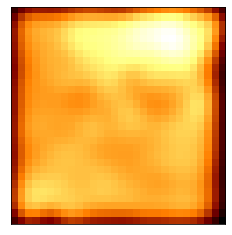

121


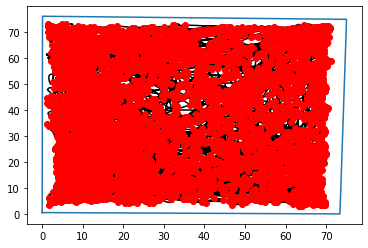

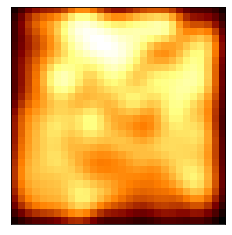

122


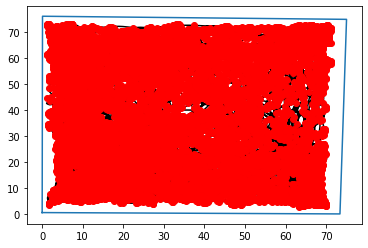

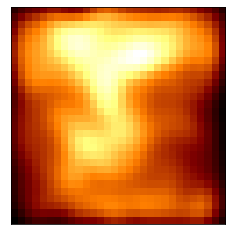

123


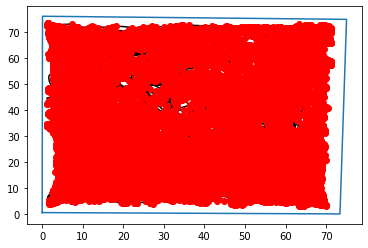

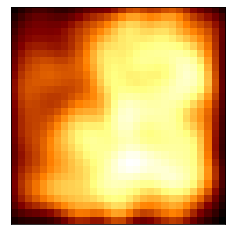

124


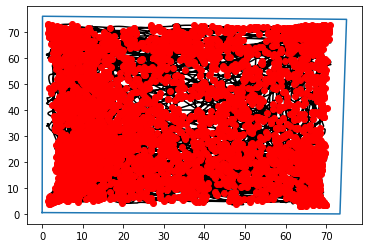

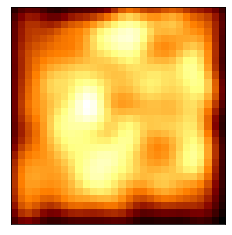

125


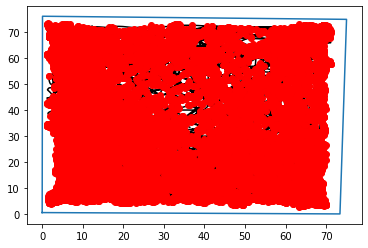

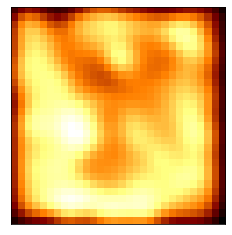

126


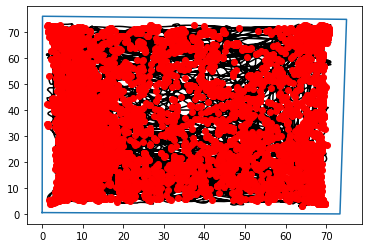

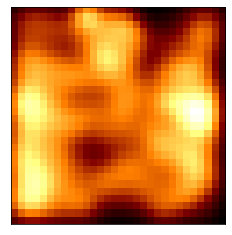

127


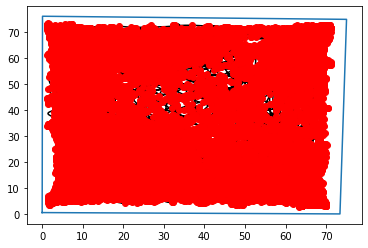

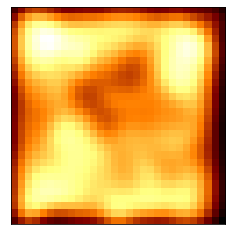

128


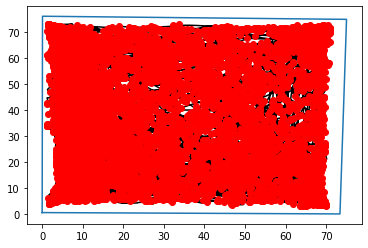

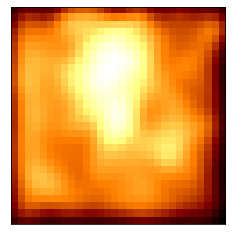

129


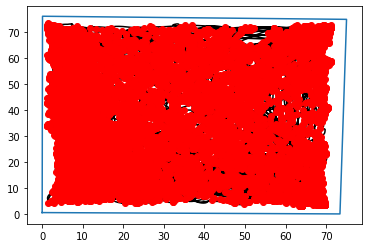

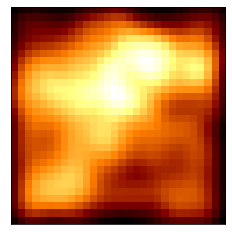

130


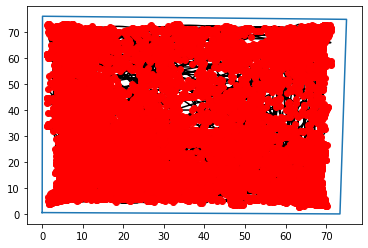

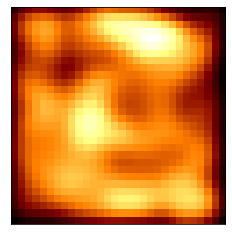

131


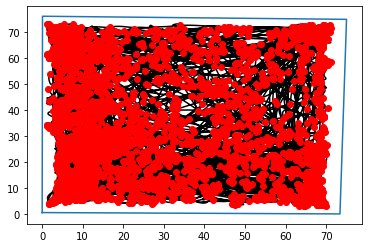

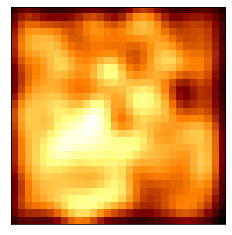

132


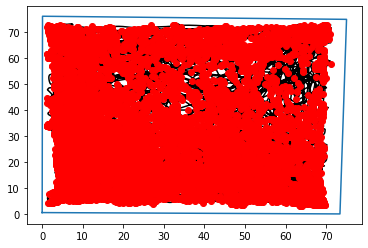

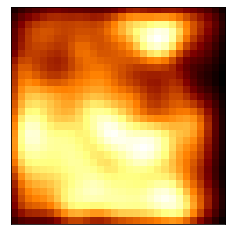

133


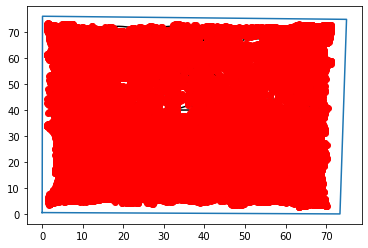

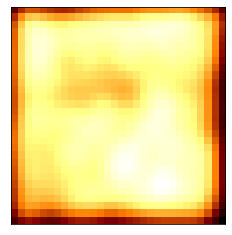

134


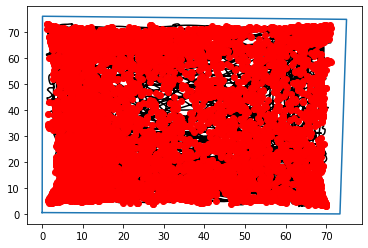

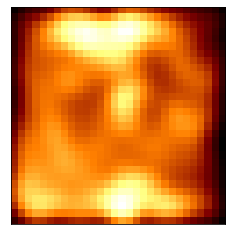

135


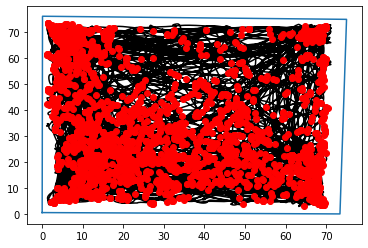

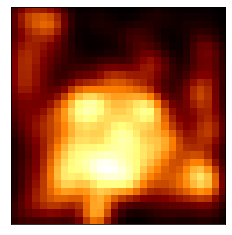

136


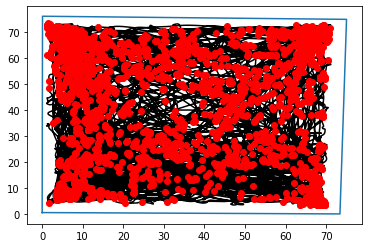

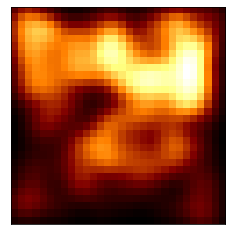

137


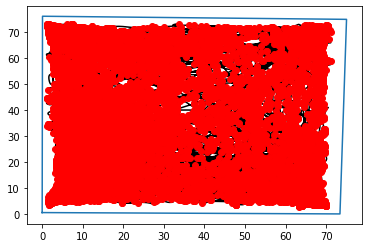

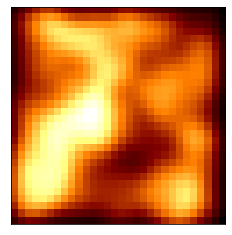

138


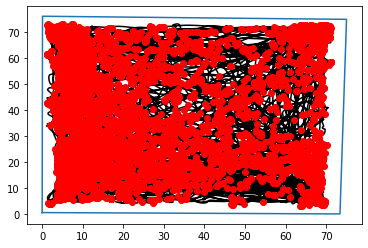

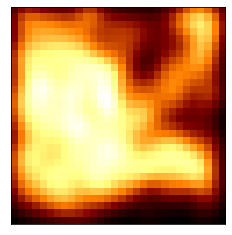

139


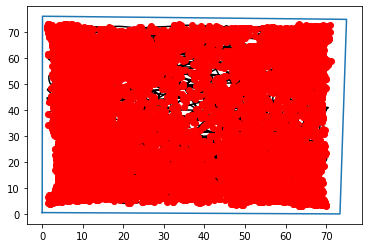

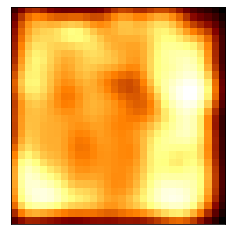

140


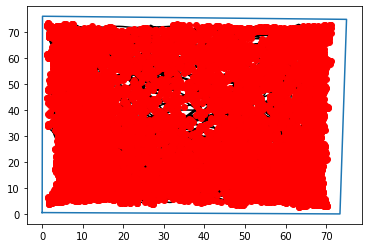

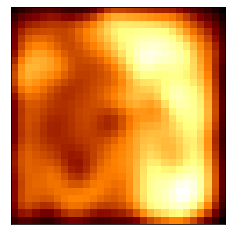

141


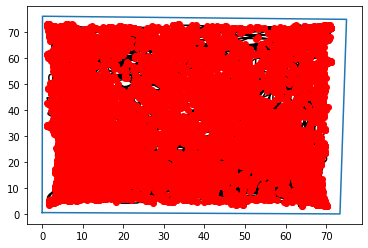

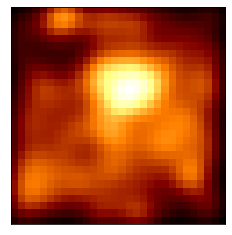

142


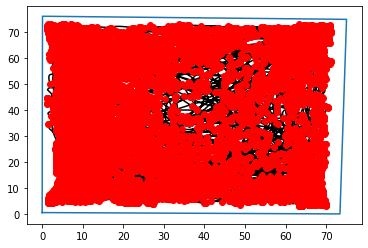

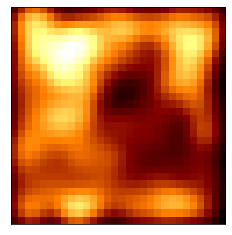

143


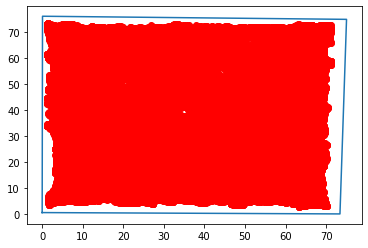

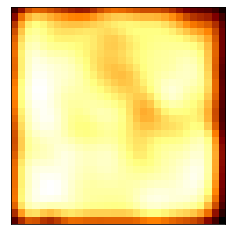

144


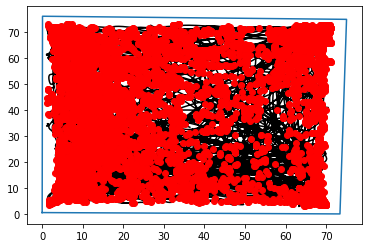

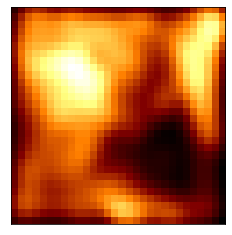

145


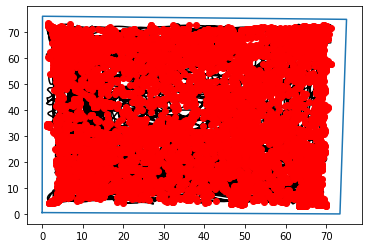

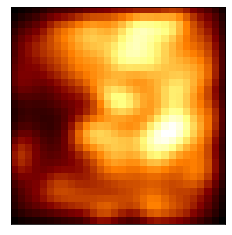

146


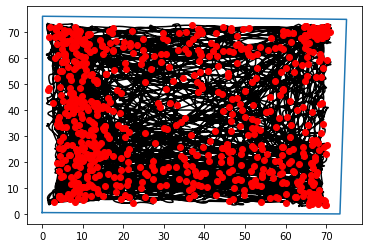

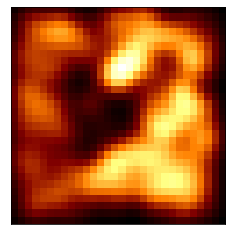

147


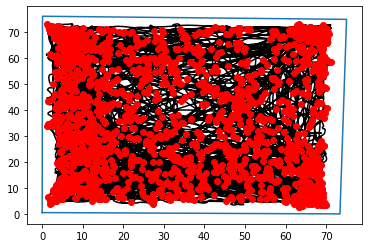

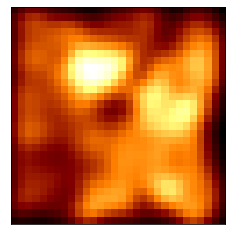

148


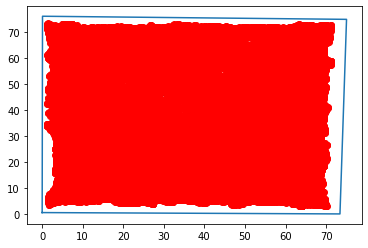

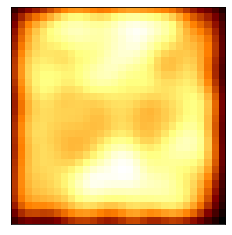

149


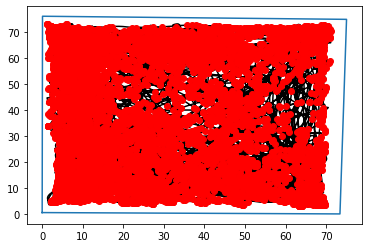

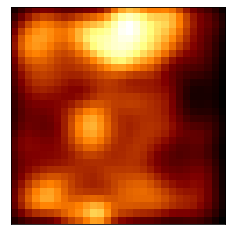

150


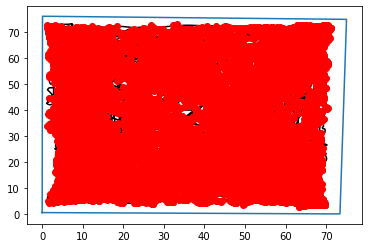

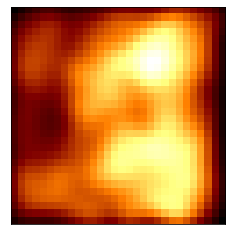

151


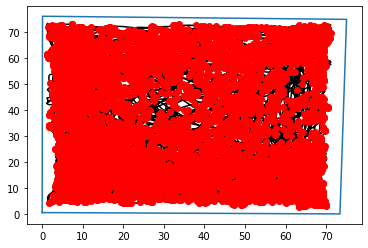

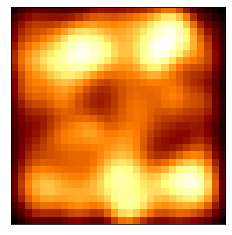

152


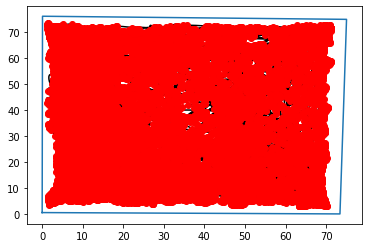

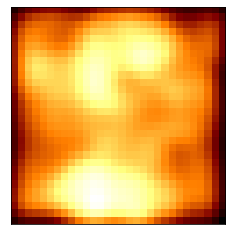

153


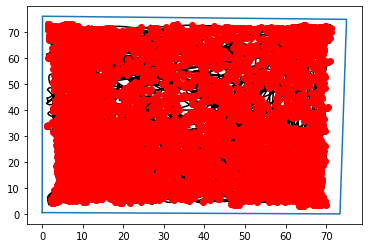

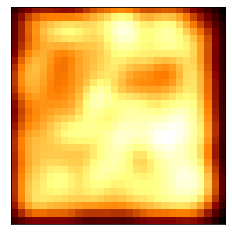

154


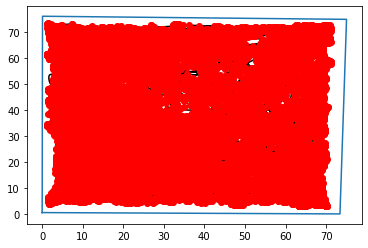

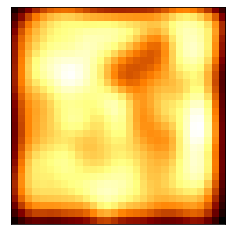

155


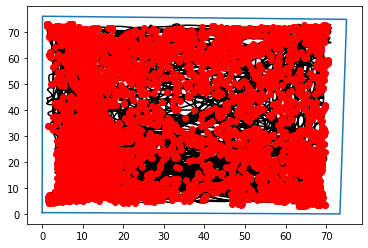

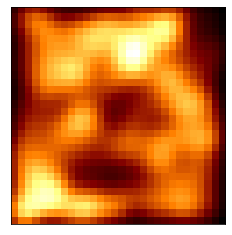

156


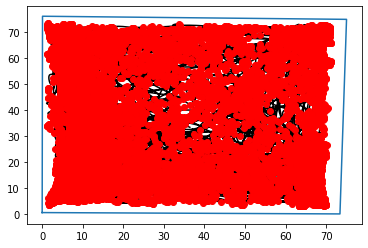

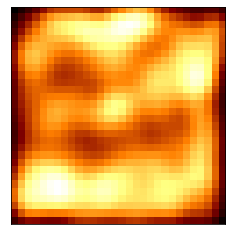

157


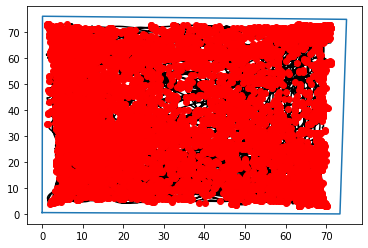

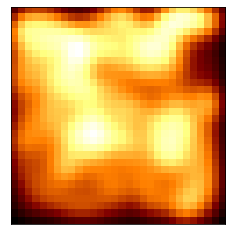

158


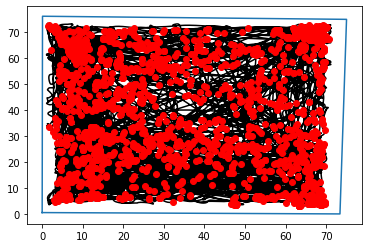

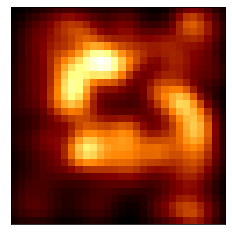

159


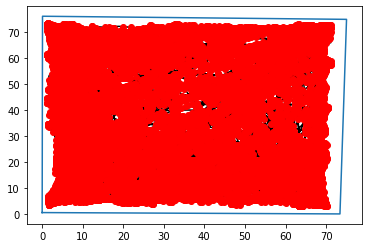

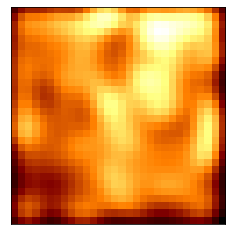

160


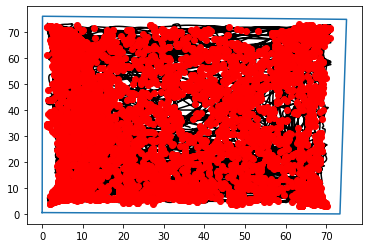

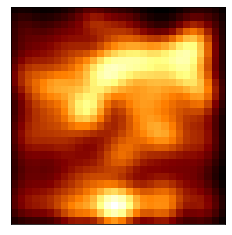

161


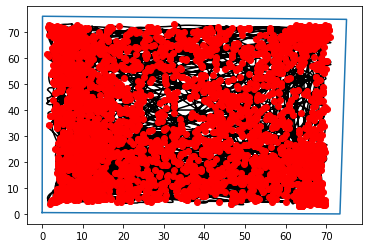

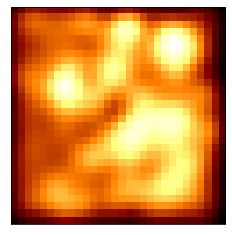

162


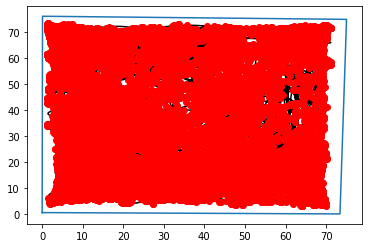

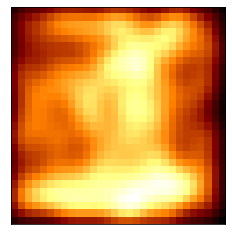

163


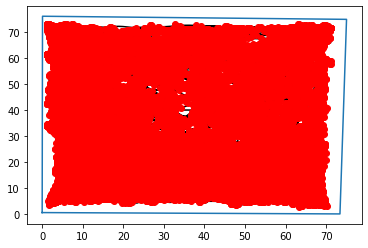

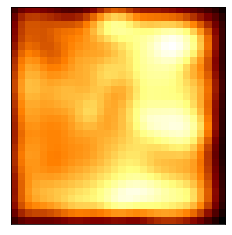

164


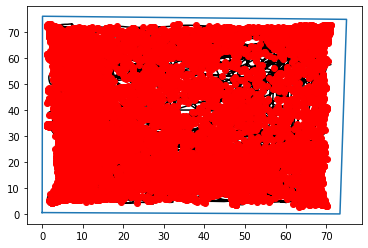

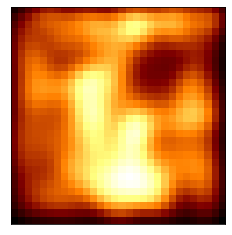

165


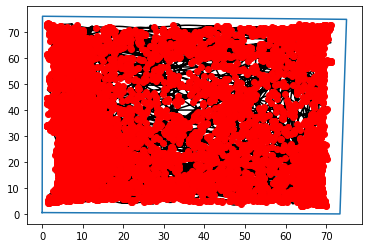

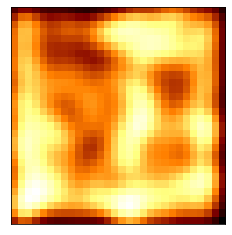

166


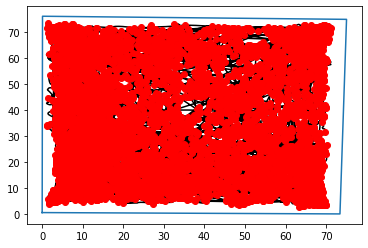

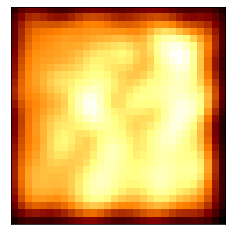

167


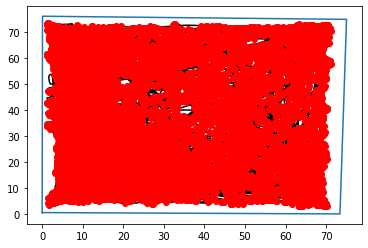

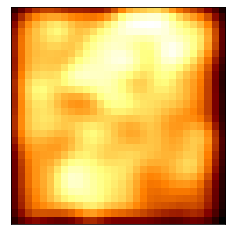

168


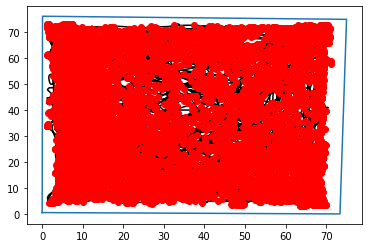

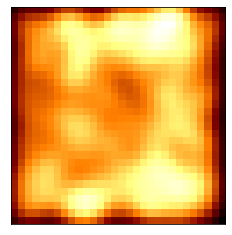

169


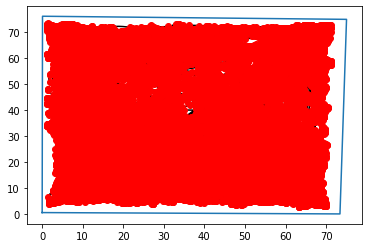

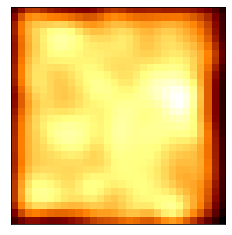

170


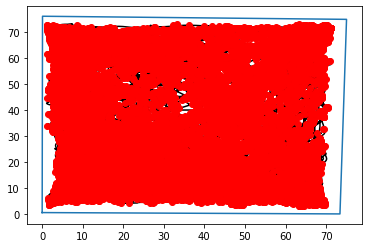

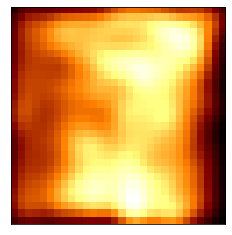

171


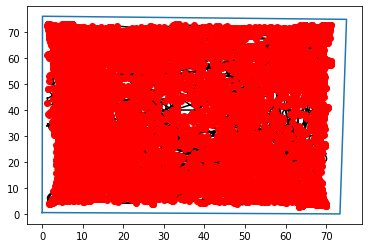

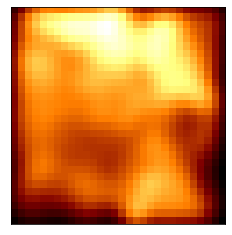

172


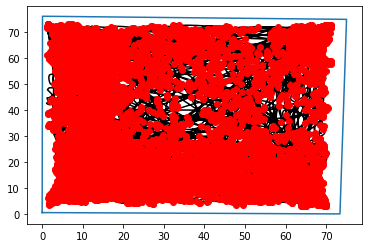

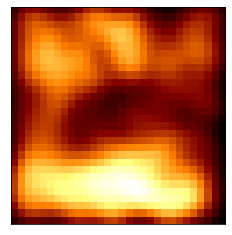

173


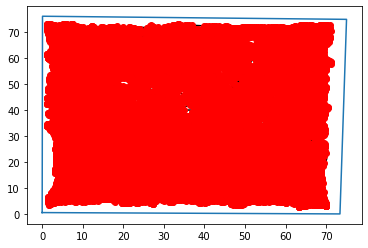

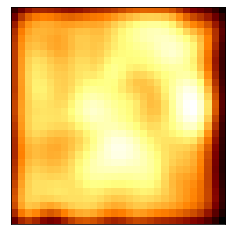

174


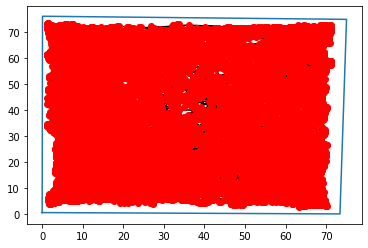

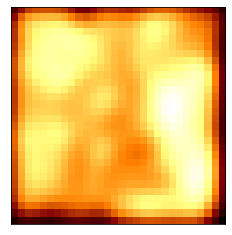

175


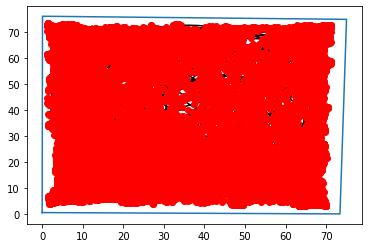

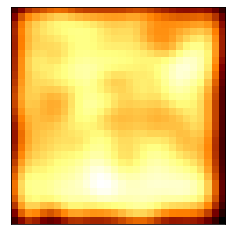

176


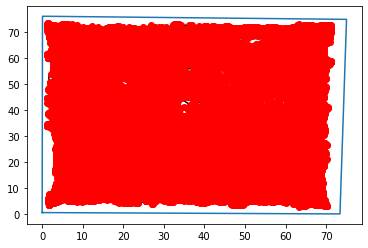

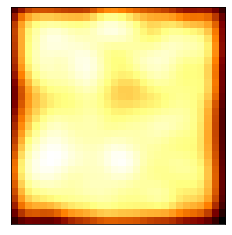

177


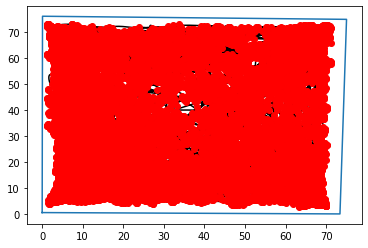

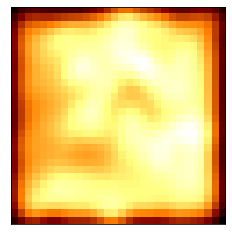

178


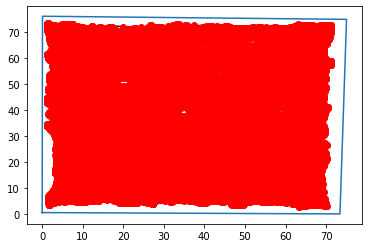

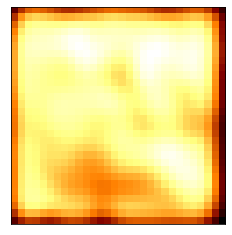

179


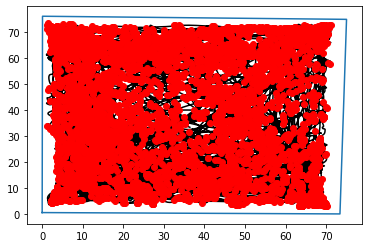

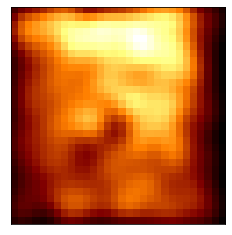

180


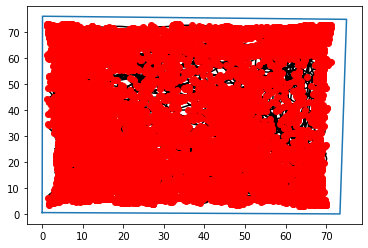

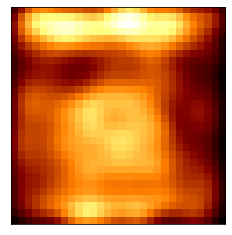

181


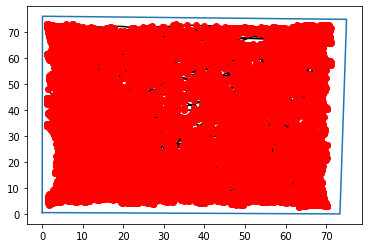

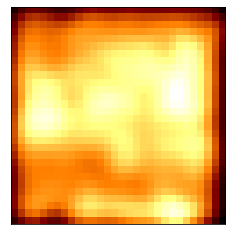

182


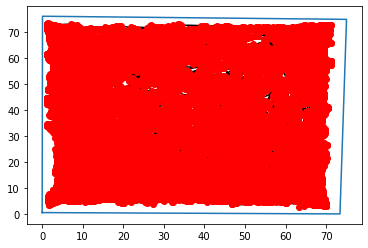

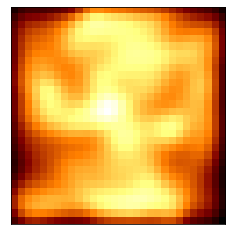

183


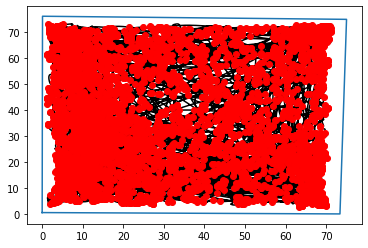

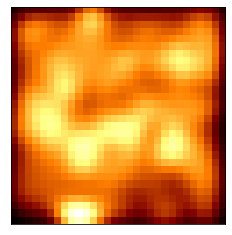

184


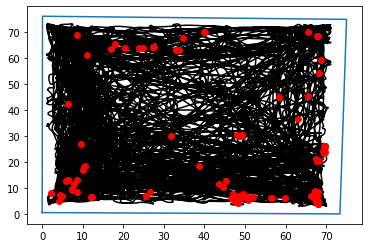

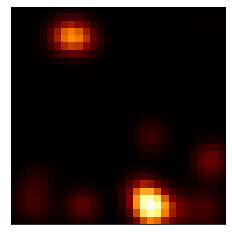

185


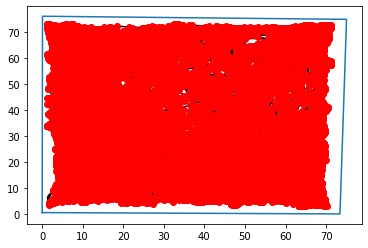

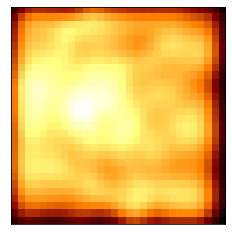

186


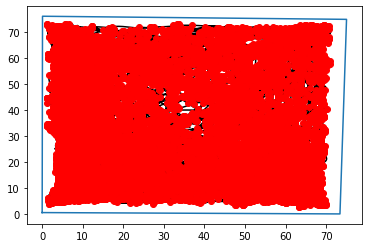

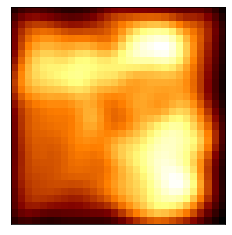

187


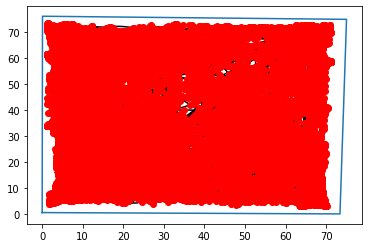

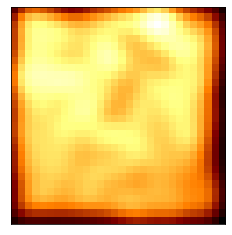

188


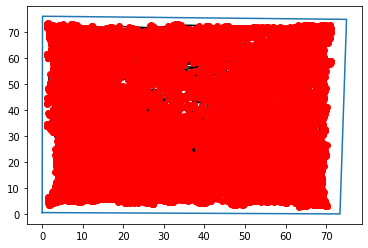

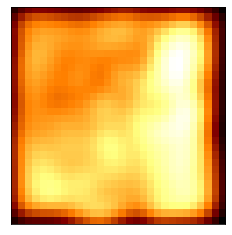

189


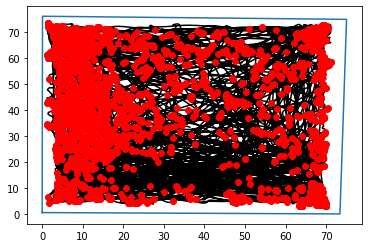

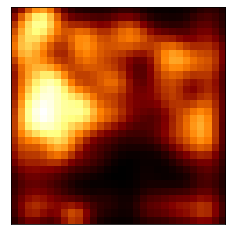

190


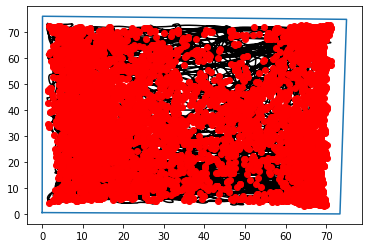

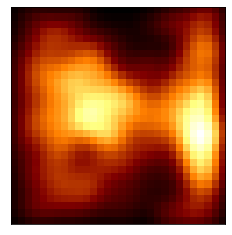

191


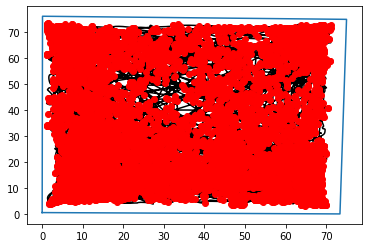

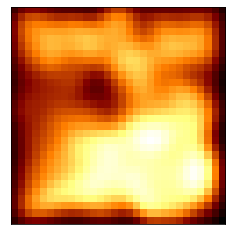

192


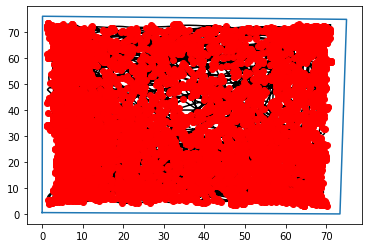

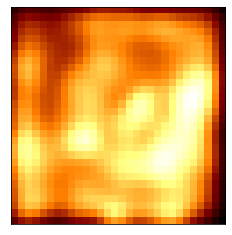

193


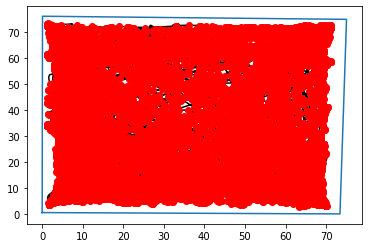

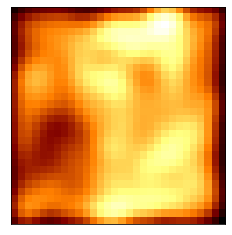

194


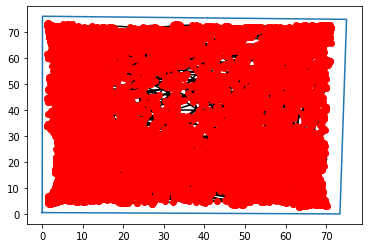

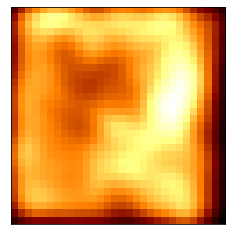

195


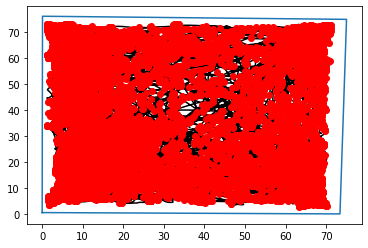

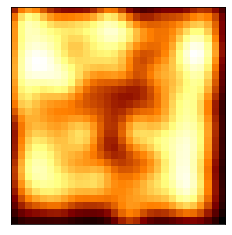

196


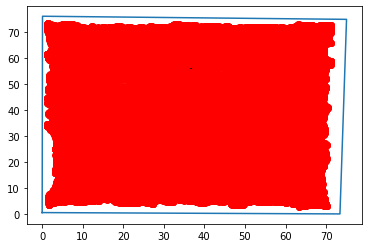

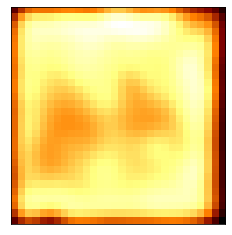

197


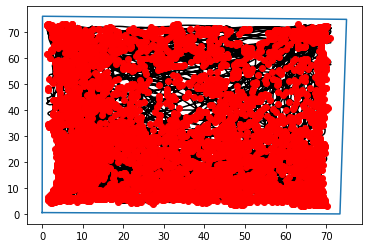

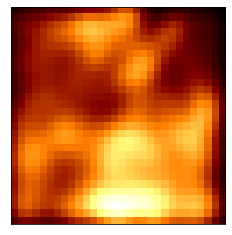

198


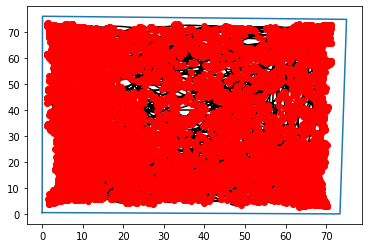

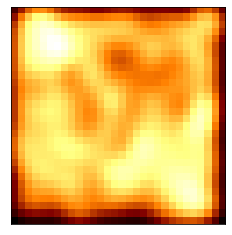

199


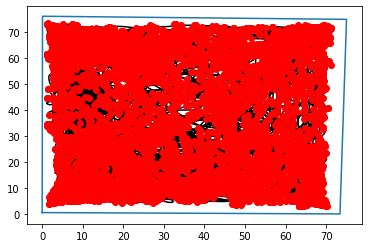

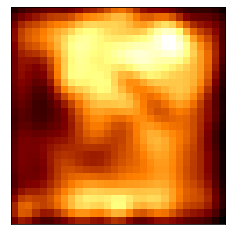

200


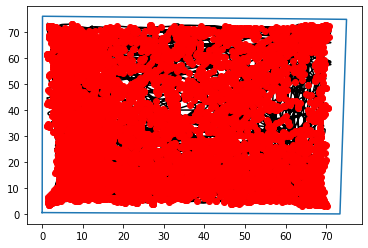

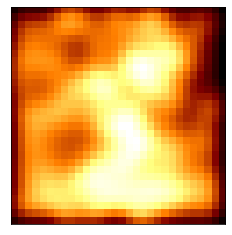

201


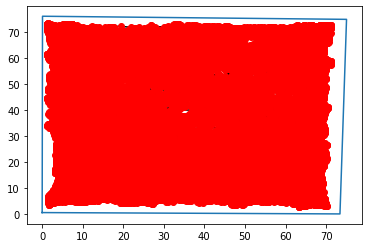

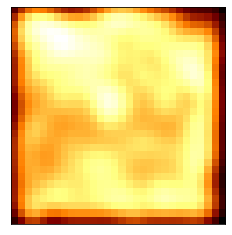

202


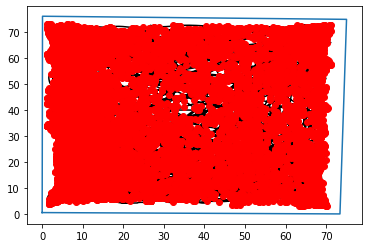

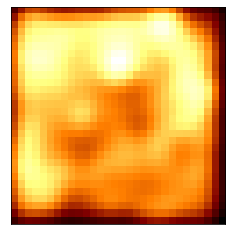

203


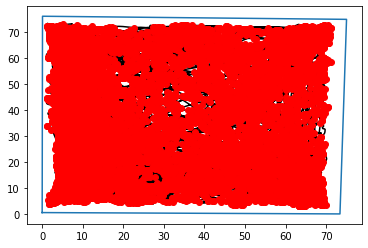

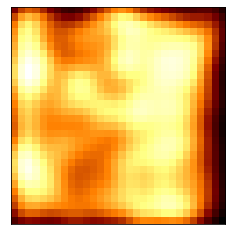

204


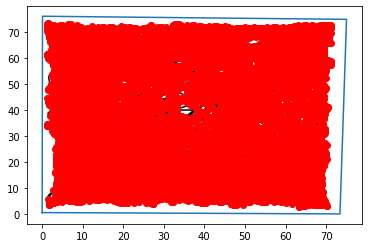

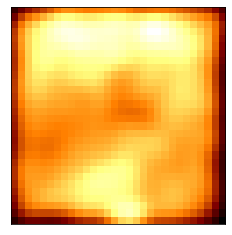

205


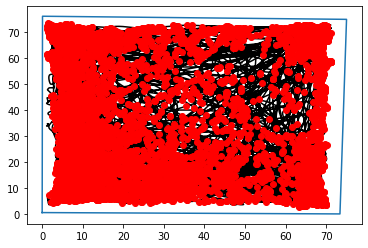

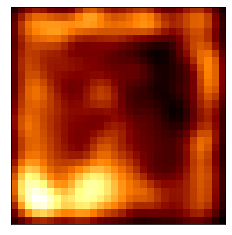

206


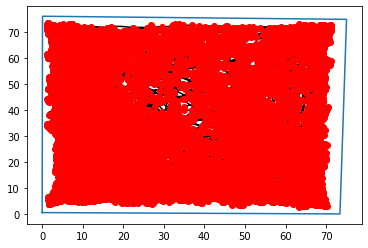

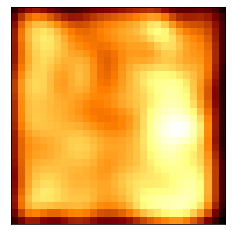

207


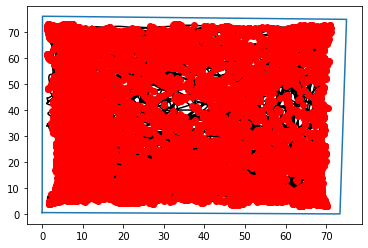

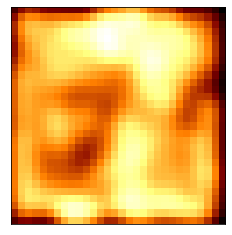

208


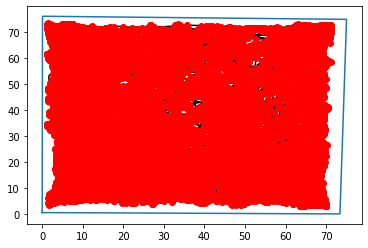

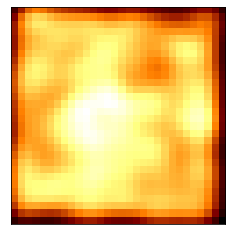

209


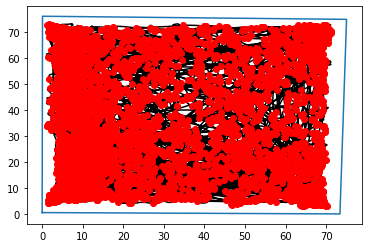

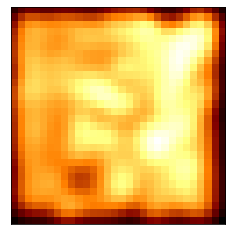

210


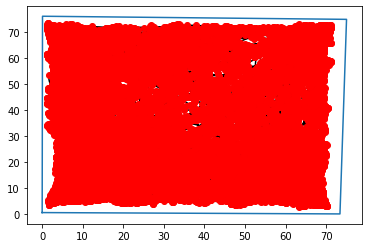

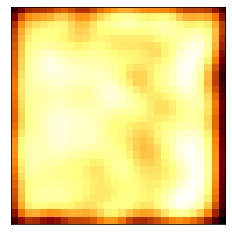

211


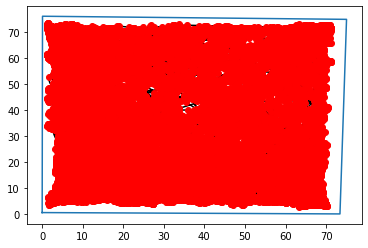

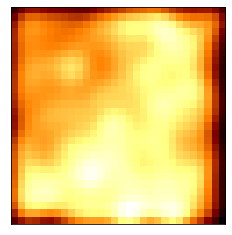

212


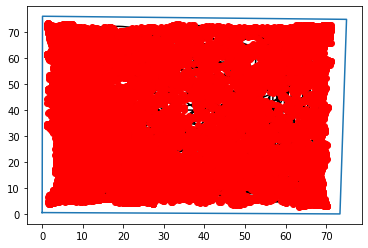

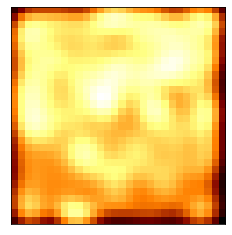

213


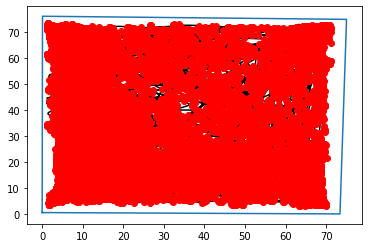

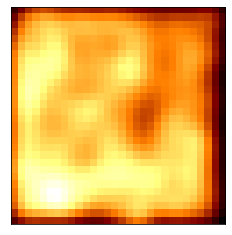

214


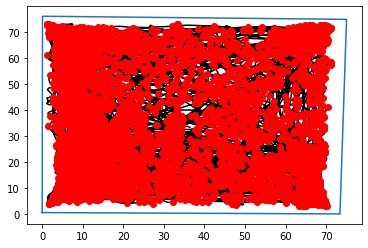

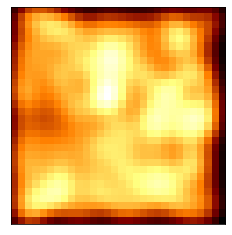

215


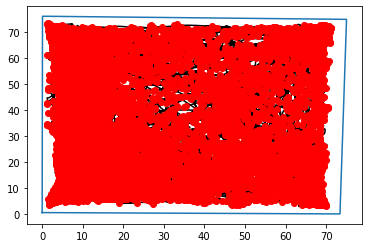

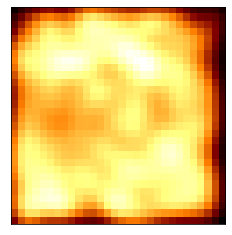

216


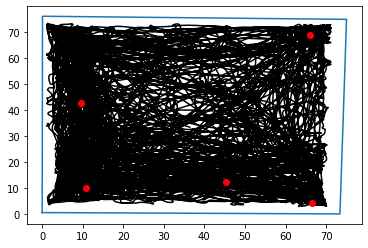

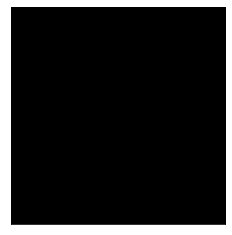

217


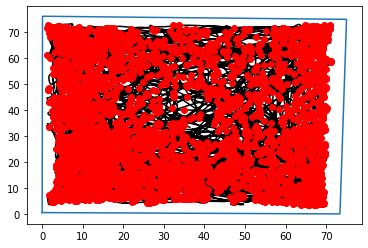

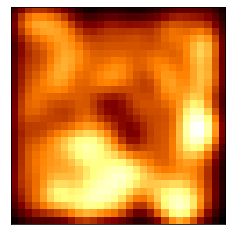

218


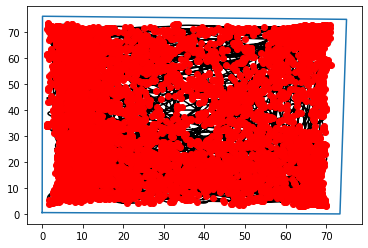

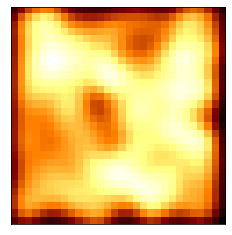

219


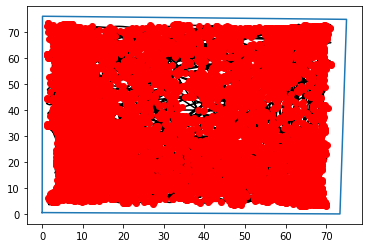

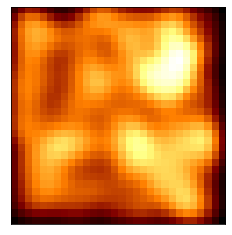

In [33]:
# edit these to your liking
base_dir = r"C:\Users\Niflheim\Desktop\VR_OF_synced\SuperCat"
figure_dir = r"C:\Users\Niflheim\Desktop\VR_OF_synced\SuperCat"
session = "AO1_231222_postop_day10"
bin_cm = 2.5

# load files
spikes_file = join(base_dir, session+"_dark01_g0_imec0_spikes.txt")
with open(spikes_file, 'rb') as file:
    spikes = pickle.load(file)

position_file = join(base_dir, session+"_OF01_g1_position.txt")
with open(position_file, 'r') as file:
    position = pd.read_csv(file)
    
arena_file = join(base_dir, session+"_OF01_g1_arena.txt")
with open(arena_file, 'r') as file:
    arena = eval(file.read())
border = arena['coordinates']['border']


for u in range(len(spikes['spikes'])):
    print(u)
    fr_map, xbins, ybins, max_fr = calc_fr_map(spikes['spikes'][u], position, border, bin_cm, smooth=True)

    # raster over paths
    f = plot_position(position, border, spikes=spikes['spikes'][u])
    #f.savefig(join(figure_dir, f"{session}_raster_unit_{u}"), format='pdf')
    
    # FR heatmap
    f = plot_heatmap(fr_map, xbins, ybins)
    #f.savefig(join(figure_dir, f"{session}_heatmap_unit_{u}"), format='pdf')